## pitchfork_review_anlaysis
**Program:** 01_pitchfork_review_analysis.ipynb <br>
**Created by:** Chris Chan<br>
**Date:** Mar 16, 2021<br>
**Purpose:** <br>
. The purpose of the project is to develop a modern jazz artist recommender/discovery based on sub-genres or non-jazz artists somehow linked to the jazz album via pitchfork review text. Upon inspection of reviews (namely jazz reviews) there is high chance of other non-jazz artist referenced to shed light on some similarity. The idea is to take these links as features or search terms in a rec system that would link to the jazz artist. The jazz artists would be cmpared as well given various topics modeled from all of the reviews.

. 1. bring in data, count vectorize, etc. <br>
. 2. preprocessing - clean, lemmatize <br>
. 3. explore:<br>
    . Basic EDA
    . try topic modeling<br>
    . sentiment analysis<br>
    . combining the two<br>

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import NMF

In [2]:
import glob
import os
from collections import defaultdict
import re
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
import nltk
import os
import spacy
import re
import string
import pickle
from itertools import cycle
import matplotlib.pyplot as plt
from nltk import stem
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
from nltk.tokenize import word_tokenize, sent_tokenize, MWETokenizer
from gensim import corpora, models, similarities, matutils
from sklearn.decomposition import TruncatedSVD, NMF
from corextopic import corextopic, vis_topic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import scattertext as st

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

In [1802]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Read in data

**We read through all the docments and build a list-of-list of words:**

In [2084]:
df = pd.read_csv('/Users/chrischan/Documents/02_Class/Metis/bootcamp/githubrepo/Metis_proj5/data/pitchfork_jazz_clean.csv')

In [2085]:
df.head()

,Unnamed: 0,artist,album,score,genre,review,othercat,othercat2,best,date,testing_formula
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","['Skip to content', 'All Results', 'Home', 'Ne...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,March 4 2021,"Skip to content, All Results, Home, News, Revi..."
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","['Skip to content', 'All Results', 'Home', 'Ne...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,February 20 2021,"Skip to content, All Results, Home, News, Revi..."
2,2,Archie Shepp / Jason Moran,Let My People Go,7.5,Jazz,These live sets between the saxophonist and pi...,"['Skip to content', 'All Results', 'Home', 'Ne...","Archie Shepp, Jason Moran, Madison Bloom, ...",0,February 15 2021,"Skip to content, All Results, Home, News, Revi..."
3,3,Patricia Brennan,Maquishti,7.4,Experimental,"Challenging but never chaotic, contemplative y...","['Skip to content', 'All Results', 'Home', 'Ne...","Patricia Brennan, Daniel Felsenthal, Experime...",0,January 19 2021,"Skip to content, All Results, Home, News, Revi..."
4,4,Baldi/Gerycz Duo,After Commodore Perry Service Plaza,7.1,Jazz,The second album of improvisational jazz from ...,"['Skip to content', 'All Results', 'Home', 'Ne...","Baldi/Gerycz Duo, Fred Thomas, Experimental,...",0,January 6 2021,"Skip to content, All Results, Home, News, Revi..."


In [2086]:
nonwords=['Skip to content', 'All Results', 'Home', 'News', 'Reviews', 'Albums', 'Tracks', 'Sunday Reviews', '8.0+ Reviews',
          'Best New Music', 'Features', 'Lists & Guides', 'Longform', 'Rising', 'Photo Galleries', 'The Pitch', 'Video',
          'Over/Under', 'Liner Notes', 'Under the Influences', 'On the Records', 'Critical Breakthroughs', 'Podcast', 'GRAMMYS 2021',
          'Newsletter', 'Advertising', 'Masthead', 'Careers', 'Contact', 'Accessibility Help', 'More Pitchfork', 'Pitchfork Music Festival Chicago',
          'Pitchfork Music Festival Paris', 'Pitchfork Music Festival Berlin', 'Pitchfork Radio', 'Home     ','GRAMMYS', 
          'Staff Picks', 'Bandcamp', 'Buy','8.0+ ','8.0+','Back to home', 'Sign','newsletter','here','pitchfork','Pitchfork']


In [2087]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       624 non-null    int64  
 1   artist           624 non-null    object 
 2   album            623 non-null    object 
 3   score            615 non-null    float64
 4   genre            615 non-null    object 
 5   review           624 non-null    object 
 6   othercat         624 non-null    object 
 7   othercat2        615 non-null    object 
 8   best             624 non-null    int64  
 9   date             615 non-null    object 
 10  testing_formula  615 non-null    object 
dtypes: float64(1), int64(2), object(8)
memory usage: 53.8+ KB


In [2088]:
df.othercat2.value_counts()

 Miles Davis, Dominique Leone                                                                                                                                                                                                        5
 NOMO, Joe Tangari, Global,  Pop/R&B                                                                                                                                                                                                 4
 Capillary Action, Joe Tangari,  Rock                                                                                                                                                                                                3
 John Zorn, Dominique Leone, Experimental                                                                                                                                                                                            3
 Alog, Mark Richardson, Electronic,  Rock                                   

In [955]:
# pat = r'\b(?:{})\b'.format('|'.join(nonwords))
# print(pat)
# #df['test'] = df['othercat'].replace("'","")
# df['othercat2'] = df['othercat'].str.replace(pat,'')
# df.head()

In [956]:
# import re
# test=[re.sub('[^,a-zA-Z0-9]+', ' ', _) for _ in df['othercat2']]
# test

### Data Cleaning

In [2089]:
breaks = lambda x: re.sub("\n", " ", x)
alphanumeric = lambda x: re.sub("\w*\d\w*", "", x)
punc_lower = lambda x: re.sub("[%s]" % re.escape(string.punctuation), "", x.lower())
#punc_lower = lambda x: re.sub("[%s]" % re.escape(string.punctuation), "",x ) # x.lower())

In [2090]:
df["review_clean"] = df["review"].map(breaks).map(alphanumeric).map(punc_lower)
df["othercat_clean"] = df["othercat2"].str.lower()
df["artist_clean"] = df["artist"].str.lower()
df["album_clean"] = df["album"].str.lower()

In [959]:
df.head(2)

,Unnamed: 0,artist,album,score,genre,review,othercat,othercat2,best,date,testing_formula,review_clean,othercat_clean,artist_clean,album_clean
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","['Skip to content', 'All Results', 'Home', 'Ne...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,March 4 2021,"Skip to content, All Results, Home, News, Revi...",fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,fresh bread
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","['Skip to content', 'All Results', 'Home', 'Ne...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,February 20 2021,"Skip to content, All Results, Home, News, Revi...",on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",femi kuti / made kuti,legacy +


### Some EDA

In [2091]:
df.describe()

,Unnamed: 0,score,best
count,624.000000,615.000000,624.000000
mean,311.500000,7.428618,0.070513
std,180.277564,1.157300,0.256215
min,0.000000,1.000000,0.000000
25%,155.750000,7.000000,0.000000
50%,311.500000,7.600000,0.000000
75%,467.250000,8.000000,0.000000
max,623.000000,10.000000,1.000000


In [2092]:
df['revdate'] = pd.to_datetime(df['date'])

In [2093]:
df=df.drop(['testing_formula','date','othercat'],axis=1)

In [2094]:
df.head(2)

,Unnamed: 0,artist,album,score,genre,review,othercat2,best,review_clean,othercat_clean,artist_clean,album_clean,revdate
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,fresh bread,2021-03-04
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",femi kuti / made kuti,legacy +,2021-02-20


### Scores over time

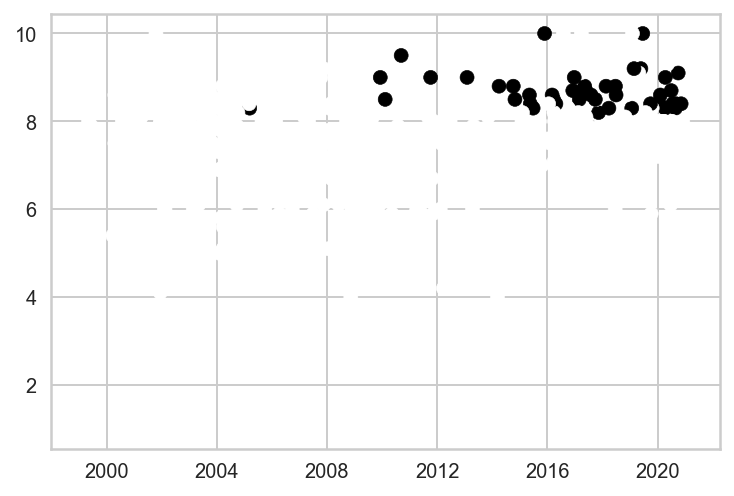

In [2096]:
%matplotlib inline
plt.scatter(y='score',x='revdate',data=df,c='best')
plt.show()

### Words per Review

In [2097]:
df['totalwords'] = [len(x.split()) for x in df['review_clean'].tolist()]

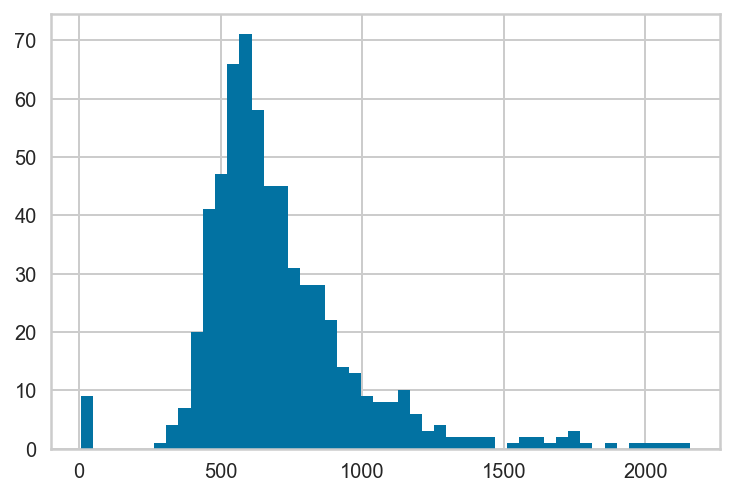

In [2098]:
%matplotlib inline
plt.hist(df['totalwords'],bins=50)
plt.show()

## Pre-processing

### Stop Words

In [2099]:
from sklearn.feature_extraction import text 

my_stop_words = nltk.corpus.stopwords.words('english')
my_stop_words.extend(nonwords)

### Lemmatize
**Lemmatizing could be tricky since many common words can be used within artist names (tribe called quest becomes tribe call**

In [2100]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
spacy_lemmatize = lambda x: " ".join([token.lemma_ for token in nlp(x)])

In [2101]:
df["review_lem"] = df["review_clean"].apply(spacy_lemmatize)
df.head(2)

,Unnamed: 0,artist,album,score,genre,review,othercat2,best,review_clean,othercat_clean,artist_clean,album_clean,revdate,totalwords,review_lem
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,fresh bread,2021-03-04,600,fiftytwo track deep this archival compendium m...
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",femi kuti / made kuti,legacy +,2021-02-20,493,on the duo ’s generationspanne double album fe...


**for future ref - everything that is capitalized could be a named entity**

In [2102]:
df.review_lem[135]

'the minneapolis synthpop band team up with a berlinbased orchestra in an attempt to reckon with the trial of our time you have to admire poliça ’s willingness to break their own mold in   with two album \' worth of hazy breakup song under their belt the minneapolis fivepiece abruptly pivot into political consciousness and trade some of their rock instinct in for a smattering of pop motif the result album united crusher falter at time but it be a goodfaith effort to engage with the national mood poliça read the room and respond accordingly poliça ’s late album be the product of another reinvention in merge with s t a r g a z e the berlinbase orchestral collective lead by conductor andré de ridder they ’ve more than double their lineup with all those extra body in the room the deep dark chasm that fracture their early work separate singer channy leaneagh ’s voice from producer ryan olson ’s rumble synth begin to fill in the result sound feel new to be sure but mostly in the sense that i

In [2103]:
#df['review_clean']=df['review_clean'].str.replace('"', '')
df['review_clean2'] = df['review_clean'].map(lambda x: re.sub(r'\W', ' ', x))

### Lets start with a basic approach:
**1. TFIDF**<br>
**2. Cosine Similarity**<br>
**3. Check recommendations**

In [974]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2903]:
my_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

**TFIDF**

In [2105]:
tfidf = TfidfVectorizer(analyzer='word', stop_words=my_stop_words)

### Apply matrix to REVIEW CLEAN text - this is what's used for COSINE SIM

In [2106]:
rev_matrix= tfidf.fit_transform(df['review_clean2'])

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'skip', 'staff', 'sunday', 'tracks', 'video'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [2107]:
rev_matrix.shape

(624, 33467)

In [2108]:
rev_matrix

<624x33467 sparse matrix of type '<class 'numpy.float64'>'
	with 203724 stored elements in Compressed Sparse Row format>

In [980]:
# take a peek at the each review and words

print('Sparse Matrix')
# A compressed version; the "sparse" matrix.
print(type(rev_matrix))
#print(rev_matrix)[0][0]

Sparse Matrix
<class 'scipy.sparse.csr.csr_matrix'>


In [981]:
# change to array for dataframe 

print ('Matrix')
rev_matrix_arr = rev_matrix.toarray()
print(type(rev_matrix_arr))
print(rev_matrix_arr)

Matrix
<class 'numpy.ndarray'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Doc word dataframe

In [2109]:
pd.DataFrame(rev_matrix_arr, columns=tfidf.get_feature_names())

,aa,aaahk,aaahs,aacm,aahs,aaly,aap,aaron,aarp,aarset,...,ólafur,órgãos,öyster,ørnes,øya,übergenre,überhip,überinfluence,風物詩,옛날이야기
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Cosine similarity (Based on Clean Review)
. This is what we can regenerate based on input parmeters (I think)

In [2110]:
cosine_similarities = cosine_similarity(rev_matrix)

In [2111]:
len(cosine_similarities)

624

In [2112]:
np.save('cosine_sim.npy', cosine_similarities)
#cosine_similarities = np.load('cosine_sim.npy')

In [2113]:
similarities = {}

In [2114]:
for i in range(len(cosine_similarities)):
    
    # Sort each element in cosine_similarities and get the indexes of the artists
    similar_indices = cosine_similarities[i].argsort()[:-50:-1] 
    
    # Store in similarities each name of the 10 most similar artists
    # Keep the first one as the main search item - and then the remaining similar artists 
    similarities[df['album'].iloc[i]] = [(cosine_similarities[i][x], df['album'][x], df['artist'][x]) for x in similar_indices][0:]

**Enter an album name to get the similarity scores of teh album**

In [2922]:
print(similarities['The Epic'])
#print(similarities.values()[0].keys()[0])

[(1.0000000000000004, 'The Epic', 'Kamasi Washington'), (0.2500581797739261, 'Harmony of Difference EP', 'Kamasi Washington'), (0.2012328072268466, 'Heaven and Earth', 'Kamasi Washington'), (0.1903413548714132, 'The Choice', 'Kamasi Washington'), (0.16745086086262906, 'A Love Supreme: The Complete Masters', 'John Coltrane'), (0.15520097059686144, 'Becoming (Music From the Netflix Original Documentary)', 'Kamasi Washington'), (0.13485983890352976, 'Planetary Prince', 'Cameron Graves'), (0.12899409527944097, 'Offering: Live at Temple University', 'John Coltrane'), (0.11762574707289261, 'The Final Tour: The Bootleg Series, Vol. 6', 'Miles Davis / John Coltrane'), (0.11714391195978822, 'Both Directions at Once: The Lost Album', 'John Coltrane'), (0.11628233135972346, 'The Complete In a Silent Way Sessions', 'Miles Davis'), (0.11179699803957624, 'The Bootleg Series, Volume 1: Live in Europe 1967', 'Miles Davis'), (0.1117333565403923, 'Interstellar Space Revisited: The Music of John Coltrane

In [ ]:
# alternate method of the above
import itertools

# Initialize limit  
N = 1
    
# Using islice() + items()  
# Get first N items in dictionary  
out = dict(itertools.islice(similarities.items(), N))  
        
# printing result   
print("Dictionary limited by K is : " + str(out))

### Content Based Recommendation

In [989]:
class ContentBasedRecommender:
    def __init__(self, matrix):
        self.matrix_similar = matrix

    def _print_message(self, album, recom_album,artist):
        rec_items = len(recom_album)        
        
        #print(f'The {rec_items} recommended albums for {album} are:')
        #print(f"{album} by {artist} ") # with {album[0][0]} similarity score")  # if can add artist sim score        
        #print(f'The {rec_items} recommended albums are:') # if can add artist search title
        
        for i in range(rec_items):
            if i==0:
                #print(f"Matched Album Number {i+1}:")
                print(f"{recom_album[i][1]} by {artist}") # with {round(recom_album[i][0],3)} similarity score")  # if can add artist sim score
                print("--------------------")
            else:    
                print(f"Recommended album based on matched (above) {i}:")            
                print(f"{recom_album[i][1]} by {recom_album[i][2]} with {round(recom_album[i][0], 3)} similarity score") 
                print("--------------------")
        
    def recommend(self, recommendation):
        artist = recommendation['artist']
        # Get album to find recommendations for
        album = recommendation['album']
        # Get number of albums to recommend
        similar_albums = recommendation['similar_albums']
        # Get the number of albums most similars from matrix similarities
        recom_album = self.matrix_similar[album][:similar_albums]
        # print each item
        self._print_message(album=album, recom_album=recom_album,artist=artist)

**instantiate rec function**

In [990]:
recommedations = ContentBasedRecommender(similarities)

### Primary function for album recs based on REVIEW CLEAN (lowercase, remove punc, no lem)

In [991]:
def artsimrec(art,artmatch=1,simalb=0):
    # get list of indeces containing the chosen word that's in the review text
    _a= df.index[df['review_clean2'].str.contains(art,na=False)]
    # get only # of keyword matches requested by user
    a=_a[:artmatch]
    
    if a.empty:
        return 'not found'
    
    # if the keyword shows up in more than one review get requested # of recs for each artist that is mentioned    
    else: # len(a)>1:
        print(f"The number of reviews containing {art} are: {len(_a)}") 
        print(f"User requested {len(a)} Matches")
        print(f"User requested {simalb} Recommended albums per Match")
        print("--------------------")
        
        for k,j in enumerate(a):
            print(f"Matched Album Number {k+1}:")
            recommendation = {
               "artist": df['artist'].iloc[j],
               "album": df['album'].iloc[j],
               "similar_albums": simalb+1 # add +1 to obtain the right number of similar albums
            }
            recommedations.recommend(recommendation)


### RUN RECOMMENDER - based on cosine sim

In [2921]:
# select text input, # of matches based on text, # of recs per match
artsimrec('kamasi',0,5)

'not found'

## Topic Modeling

### Get DF with Review only

In [1016]:
df_rev = df['review_lem']
df_rev.head(3)

0    fiftytwo track deep this archival compendium m...
1    on the duo ’s generationspanne double album fe...
2    these live set between the saxophonist and pia...
Name: review_lem, dtype: object

In [1017]:
# Import TfidfVectorizer and NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF    

### Start with Genre Topics

In [1155]:
# Makes sense to add words like 'jazz' to stopwords

stopadd = ['band','time','get','take','work','detail','familiar','also','miles','mile','davis','coltrane','song','year','way','instrument','minute']
my_stop_words.extend(stopadd)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Alternative to Topic Modeling for Genre

### Use Genre List from MusicBrainz to match keywords in reviews

### Phrase Matching

In [1315]:
import spacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import PhraseMatcher
phrase_matcher = PhraseMatcher(nlp.vocab)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Function to match phrases in review against music brainz genre list**

In [1422]:
# Phrase Matcher code
#importing all required libraries
import os
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.matcher import PhraseMatcher

#function that does phrase matching and builds a candidate profile
def create_profile(file):
    
    text = file
    keyword_dict = pd.read_csv('../data/mbrainz_genres.csv')
    stats_words = [nlp(text) for text in keyword_dict['subgenre'].dropna(axis = 0)]

    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Stats', None, *stats_words)

    doc = nlp(text)
    
    d = []  
    matches = matcher(doc)
    
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
        span = doc[start : end]  # get the matched slice of the doc
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())
    
    ## convertimg string of keywords to dataframe
    _df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    _df1 = pd.DataFrame(_df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    _df2 = pd.DataFrame(_df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    _df3 = pd.concat([_df1['Subject'],_df2['Keyword'], _df2['Count']], axis =1) 
    _df3['Count'] = _df3['Count'].apply(lambda x: x.rstrip(")"))
    
    # initialize list of lists 
    cdata = [[i]] 
  
    # Create the pandas DataFrame 
    cdata2 = pd.DataFrame(cdata, columns = ['album']) 
    
    dataf = pd.concat([ cdata2['album'], _df3['Subject'], _df3['Keyword'], _df3['Count']], axis = 1)    
    dataf['album'].fillna(dataf['album'].iloc[0], inplace = True)
    #print("dataf 2",dataf)
    
    return(dataf)
        
#function ends
        
#code to execute/call the above functions
final_database=pd.DataFrame()
i = 0 

for i in range(0,len(df)):
    file = df['review_clean'].iloc[i]
    dat = create_profile(file)
    final_database = final_database.append(dat)
    i +=1

# transpose - convert nans to zero
df_wide = final_database.pivot("album","Keyword","Count")    
df_wide.fillna(0,inplace=True)
print("df wide",df_wide)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


df wide Keyword  NaN acid house  acid jazz  acid rock  acoustic blues  afrobeat   \
album                                                                      
0.0        0           0          0          0               0         0   
1.0        0           0          0          0               0         4   
2.0        0           0          0          0               0         0   
3.0        0           0          0          0               0         0   
4.0        0           0          0          0               0         0   
...      ...         ...        ...        ...             ...       ...   
619.0      0           0          0          0               0         0   
620.0      0           0          0          0               0         0   
621.0      0           0          0          0               0         0   
622.0      0           0          0          0               0         0   
623.0      0           0          0          0               0         0   

Key

### Pickle the file

In [1616]:
import pickle

pickling_on = open("final_database.pickle","wb")
pickle.dump(final_database, pickling_on)
pickling_on.close()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# pickle_off = open("final_database.pickle","rb")
# final_database = pickle.load(pickle_off)

## EDA 
- Get value counts per genre

In [1423]:
final_database.Keyword.value_counts(1)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


jazz                 0.106478
musical              0.043187
rock                 0.036982
funk                 0.034252
pop                  0.031521
                       ...   
rap rock             0.000248
progressive rock     0.000248
boogiewoogie         0.000248
uk garage            0.000248
klezmer              0.000248
Name: Keyword, Length: 225, dtype: float64

In [1424]:
gen_count=final_database.Keyword.value_counts()
type(gen_count)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


pandas.core.series.Series

In [1425]:
gen_count.to_csv(r'../data/gen_counts.csv')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Viz Ideas - Heatmap - Genre over time<br>
Word cloud of genres**

In [1428]:
final_database.head()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,album,Subject,Keyword,Count
0,0.0,Stats,jazz,2
1,0.0,Stats,free jazz,1
2,0.0,Stats,cloud rap,1
3,0.0,Stats,chiptune,1
4,0.0,Stats,ambient,2


### Bring in review dates - left join the main DF

**rename columns for merge**

In [1447]:
df.rename(columns={'Unnamed: 0': 'revID'} , inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1448]:
final_database.rename(columns={'album': 'revID'} , inplace=True)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1498]:
#test2 = test2["revID"].astype(int)
df_long=final_database.merge(df, on='revID', how='left')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**CC : using DF produced later to bring back and redo heatmap on larger genres**

In [1499]:
df_long_limited=df_long[['Keyword','Count','revdate']]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1500]:
df_long_limited['year'] = df_long_limited['revdate'].dt.year
df_long_limited.drop(['revdate'],axis=1,inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1501]:
df_long_limited.head(2)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Keyword,Count,year
0,jazz,2,2021.0
1,free jazz,1,2021.0


In [1502]:
df_long_limited.fillna(0,inplace=True)
df_long_limited['Count']=df_long_limited['Count'].astype(str).astype(int)
df_long_limited.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4040 entries, 0 to 4039
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Keyword  4040 non-null   object 
 1   Count    4040 non-null   int64  
 2   year     4040 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 126.2+ KB


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Group by and Pivot to make genres columns**

In [1472]:
# Gropu by year
x=df_long_limited.groupby(['year']).sum()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2042]:
genre_time=pd.pivot_table(df_long_limited, index = 'year', values = 'Count', columns = 'Keyword', aggfunc = 'sum')
genre_time.fillna(0,inplace=True)
genre_time.drop((0.0),inplace=True)
genre_time

Keyword,0,acid house,acid jazz,acid rock,acoustic blues,afrobeat,ambient,ambient techno,americana,art rock,...,trap,trip hop,turntablism,uk garage,underground hiphop,vocal house,vocal jazz,waltz,west coast hiphop,western swing
year,,,,,,,,,,,,,,,,,,,,,
1999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2002.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,1.0,0.0,...,2.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,3.0,0.0
2003.0,0.0,0.0,2.0,0.0,0.0,2.0,7.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2004.0,0.0,0.0,2.0,0.0,0.0,6.0,12.0,0.0,1.0,0.0,...,2.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0
2005.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2007.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2055]:
# remove jazz
genre_time.columns = genre_time.columns.str.strip()
genre_time_limited=genre_time.drop('jazz',axis=1)
# transpose
genre_time_T = genre_time_limited.T
genre_time_T = genre_time_T.iloc[1:]
genre_time_T

year,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,...,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0
Keyword,,,,,,,,,,,,,,,,,,,,,
acid house,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
acid jazz,0.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
acid rock,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
acoustic blues,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
afrobeat,0.0,0.0,0.0,0.0,2.0,6.0,5.0,1.0,2.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,10.0,2.0,10.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vocal house,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vocal jazz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
waltz,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0


### Data viz - heatmap of genre over time

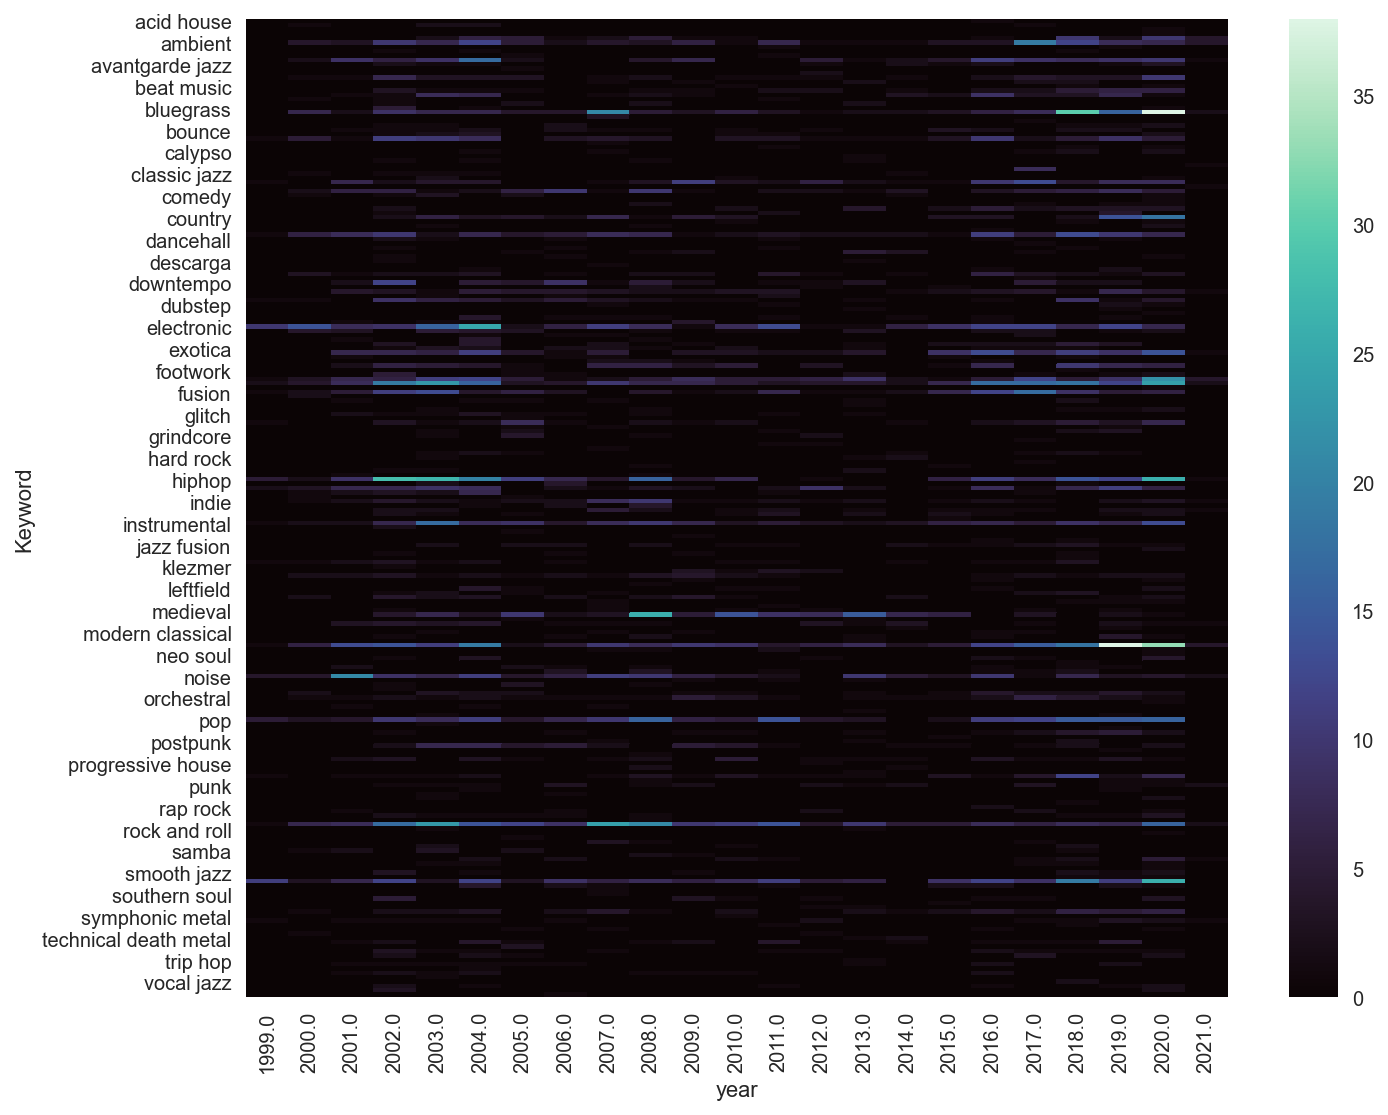

In [2056]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(genre_time_T,fmt="d", cmap="mako")
plt.show()

**Take only the top 30 genres**

In [2788]:
# sum across columns
genre_time_T['total_genres'] = genre_time_T.sum(axis=1)

# sort by total
genre_time_T_top20=genre_time_T.sort_values(by=['total_genres'],ascending=False).nlargest(20, 'total_genres')

# take top 20
genre_time_T_top20.drop(['total_genres'],axis=1,inplace=True)

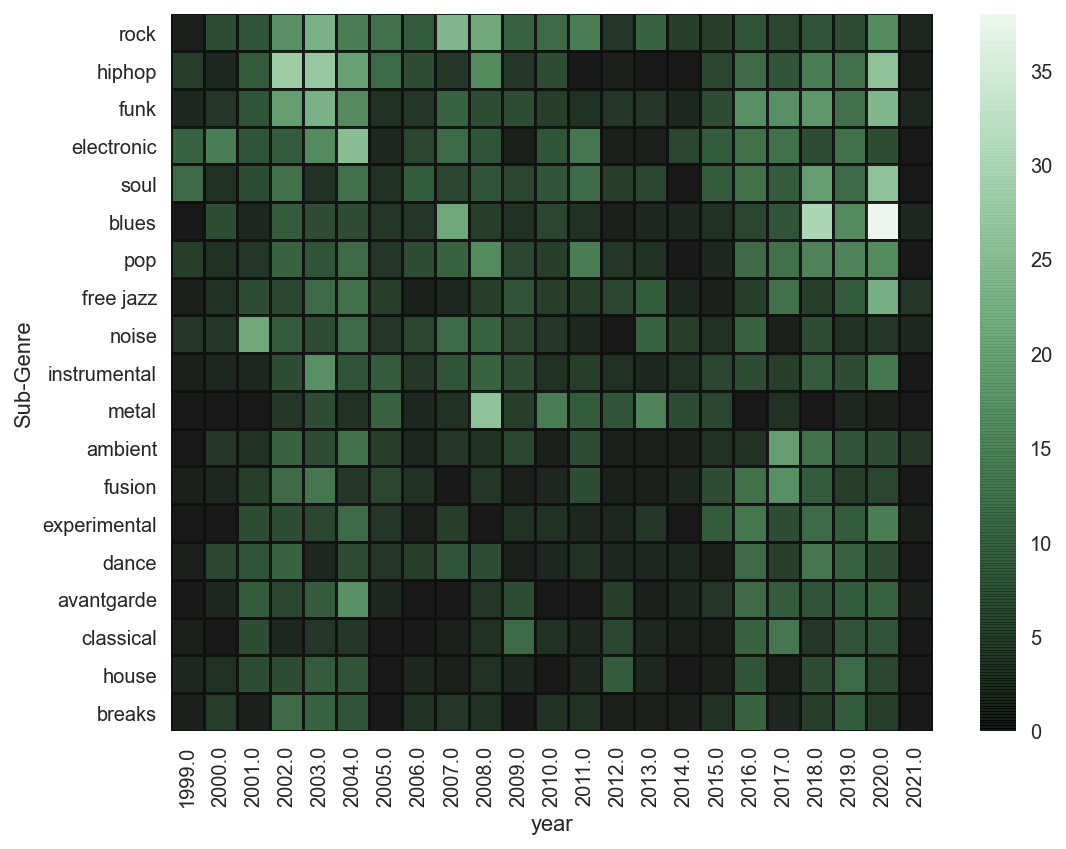

In [2825]:
gentime_df_rmv = genre_time_T_top20[1:]

x=sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)

fig, ax = plt.subplots(figsize=(8, 6))
#cmap= sns.cubehelix_palette()
kwargs = {'alpha':.9,'linewidth':1, 'linestyle':'-', 'linecolor':'k','rasterized':False, 'edgecolor':'w', "capstyle":'projecting',}
sns.heatmap(gentime_df_rmv, cmap=x , **kwargs )
plt.ylabel('Sub-Genre')
plt.tight_layout()
plt.savefig('../img/heatmap_subgenre.png')
plt.savefig('../img/heatmap_subgenre.svg')

**Output to csv**

In [2811]:
genre_time_T_top20.to_csv('../data/df_genre_time.csv')

### More EDA on genres over time
- pull artist names and albums for specified timeframes

### Count top words used in reviews
- top 20 over time

In [2137]:
mystops = nltk.corpus.stopwords.words('english')
mystops.extend(my_stop_words)

In [2201]:
stopadd = ['like','electronic','experimental','pop/r&b','rock','rough','trade','soundcloud','rap','j','&','metal','global']
mystops.extend(stopadd)

In [2310]:
# THis is a list from raw data = obtaining named entities from reviews!
# file = open('../data/rev_corp_test.txt', encoding="utf8")
# a= file.read()
test = pd.read_csv('../data/rev_corp_test.txt', encoding="utf8")

In [2327]:
# strip blank spaces and other nums after periods
res = [] 
for ele in test:
    x=ele.split(".",1)
    y=x[0]
    z=y.strip()
    res.append(z)

In [2328]:
res

['Sam Gendel',
 'Jay Balfour',
 'Sam Gendel',
 'covered',
 'Ocarina of Time',
 '4444',
 'Champs EÃÅlyseÃÅes',
 'Femi Kuti',
 'Made Kuti',
 'Joey Akan',
 'Global',
 'Fela Kuti',
 'Afrobeat',
 'Seun Kuti',
 'Femi Kuti',
 'Made',
 'Archie Shepp',
 'Jason Moran',
 'Madison Bloom',
 'Archie Shepp',
 'Let My People Go',
 'Jason Moran',
 'said',
 'recorded an album',
 'Patricia Brennan',
 'Daniel Felsenthal',
 'Experimental',
 'Patricia Brennan',
 'Baldi/Gerycz Duo',
 'Fred Thomas',
 'Experimental',
 'Cloud Nothings',
 'jams',
 'several',
 'abstract',
 'side projects',
 'Pharoah Sanders',
 'Blessed Repair',
 'Duo Exchange',
 'Roland Haynes',
 'Marty Sartini Garner',
 'Roland Haynes',
 'Pharoah Sanders',
 'Jandek',
 'DJ Khaled',
 'Association for the Advancement of Creative Musicians',
 'Archie Shepp',
 'Alice Coltrane',
 'Herbie Hancock',
 'Head Hunters',
 'Jimi Hendrix',
 'Flying Lotus',
 'Chick Corea',
 'Grateful Dead',
 'Rough Trade',
 'Winston C',
 'Connor Beckett McInerney',
 'Pop/R&B',


In [2333]:
remwords = ['Electronic', 'Experimental','Pop/R&B', 'Rock','Rough Trade', 'SoundCloud', 'Rap', 'Metal','Global','','Seth Colter Walls',
           'Mark Richardson','Joe Tangari','Andy Beta','Dominique Leone','Chris Dahlen', 'Brian Howe','Marc Masters','Paul Cooper',
            'Grayson Currin','Matthew Murphy','Marcus J','Nate Patrin','Mike Powell','Marty Sartini Garner', 'Kind of Blue','Jonathan Zwickel',
            'Jay Balfour','Bitches Brew','Dean Van Nguyen','Grayson Haver Currin' ,'Steve Lehman','Matthew Kassel','Folk/Country','Nate Chinen'
            'Phillip Mlynar' ,'Mark Martelli','Daniel Felsenthal','Steven Arroyo','A Love Supreme']

for word in list(res):  # iterating on a copy since removing will mess things up
    if word in remwords:
        res.remove(word)

In [2334]:
from collections import Counter
counts = Counter(res)
#counts.most_common(3)
print(counts)

Counter({'Miles Davis': 49, 'John Coltrane': 40, 'Sun Ra': 23, 'Kamasi Washington': 23, 'Pharoah Sanders': 21, 'Alice Coltrane': 21, 'Thundercat': 20, 'Ornette Coleman': 20, 'Nina Simone': 18, 'Robert Glasper': 17, 'Cecil Taylor': 16, 'Herbie Hancock': 15, 'John Zorn': 15, 'Anthony Braxton': 14, 'Flying Lotus': 13, 'Makaya McCraven': 13, 'Duke Ellington': 13, 'Mary Halvorson': 13, 'Vijay Iyer': 12, 'Daedelus': 12, 'Kendrick Lamar': 11, 'Albert Ayler': 11, 'Charles Mingus': 11, 'J Dilla': 10, 'Jeff Parker': 10, 'Matthew Shipp': 10, 'Gil Scott-Heron': 9, 'Thelonious Monk': 9, 'Shabaka Hutchings': 9, 'Esperanza Spalding': 9, 'Craig Taborn': 9, 'Wadada Leo Smith': 9, 'Amon Tobin': 9, 'Zs': 9, 'Don Cherry': 8, 'Brian Eno': 8, 'Christian Scott aTunde Adjuah': 8, 'Four Tet': 8, 'Eric Dolphy': 7, 'Okkyung Lee': 7, 'Stevie Wonder': 7, 'Chet Baker': 7, 'Nels Cline': 7, 'Bonobo': 7, 'Billie Holiday': 7, 'Sam Gendel': 6, 'Piotr Orlov': 6, 'Tomeka Reid': 6, 'Nate Chinen': 6, 'Art Ensemble of Chicag

How many most common words to print: 50

OK. The 50 most common words are as follows

Miles Davis :  49
John Coltrane :  40
Sun Ra :  23
Kamasi Washington :  23
Pharoah Sanders :  21
Alice Coltrane :  21
Thundercat :  20
Ornette Coleman :  20
Nina Simone :  18
Robert Glasper :  17
Cecil Taylor :  16
Herbie Hancock :  15
John Zorn :  15
Anthony Braxton :  14
Flying Lotus :  13
Makaya McCraven :  13
Duke Ellington :  13
Mary Halvorson :  13
Vijay Iyer :  12
Daedelus :  12
Kendrick Lamar :  11
Albert Ayler :  11
Charles Mingus :  11
J Dilla :  10
Jeff Parker :  10
Matthew Shipp :  10
Gil Scott-Heron :  9
Thelonious Monk :  9
Shabaka Hutchings :  9
Esperanza Spalding :  9
Craig Taborn :  9
Wadada Leo Smith :  9
Amon Tobin :  9
Zs :  9
Don Cherry :  8
Brian Eno :  8
Christian Scott aTunde Adjuah :  8
Four Tet :  8
Eric Dolphy :  7
Okkyung Lee :  7
Stevie Wonder :  7
Chet Baker :  7
Nels Cline :  7
Bonobo :  7
Billie Holiday :  7
Sam Gendel :  6
Piotr Orlov :  6
Tomeka Reid :  6
Nate Chinen 

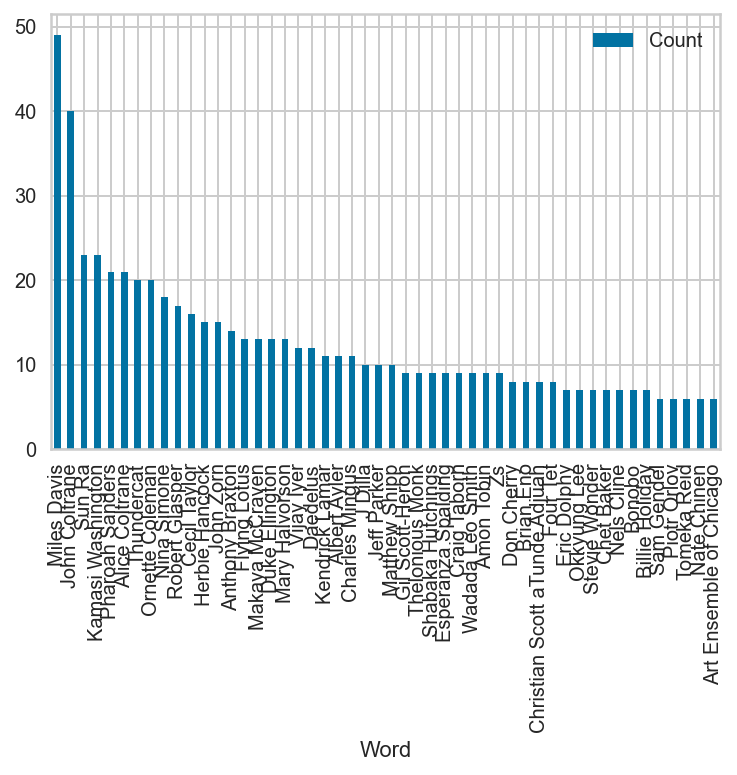

In [2425]:
import collections
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Read input file, note the encoding is specified here 
# It may be different in your text file
# file = open('../data/rev_corp_test.txt', encoding="utf8")
# a= file.read()
# Stopwords

# stopwords = set(line.strip() for line in open('stopwords.txt'))
# stopwords = stopwords.union(set(['mr','mrs','one','two','said']))
# Instantiate a dictionary, and for every word in the file, 
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}

# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in res: # a.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in mystops: #my_stop_words: #stopwords:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)

for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)

# Close the file
#file.close()
# Create a data frame of the most common words 
# Draw a bar chart
lst = word_counter.most_common(n_print)
dfwords = pd.DataFrame(lst, columns = ['Word', 'Count'])
dfwords.plot.bar(x='Word',y='Count')

### Output DF to CSV for EDA Graph

In [2433]:
dfwords.to_csv('../data/df_top_mentions.csv')

**Testing different cuts of data**

In [2426]:
def topmention(x=50):
    dfment=dfwords[0:x]
    return dfment

In [2428]:
dfment = topmention(50)

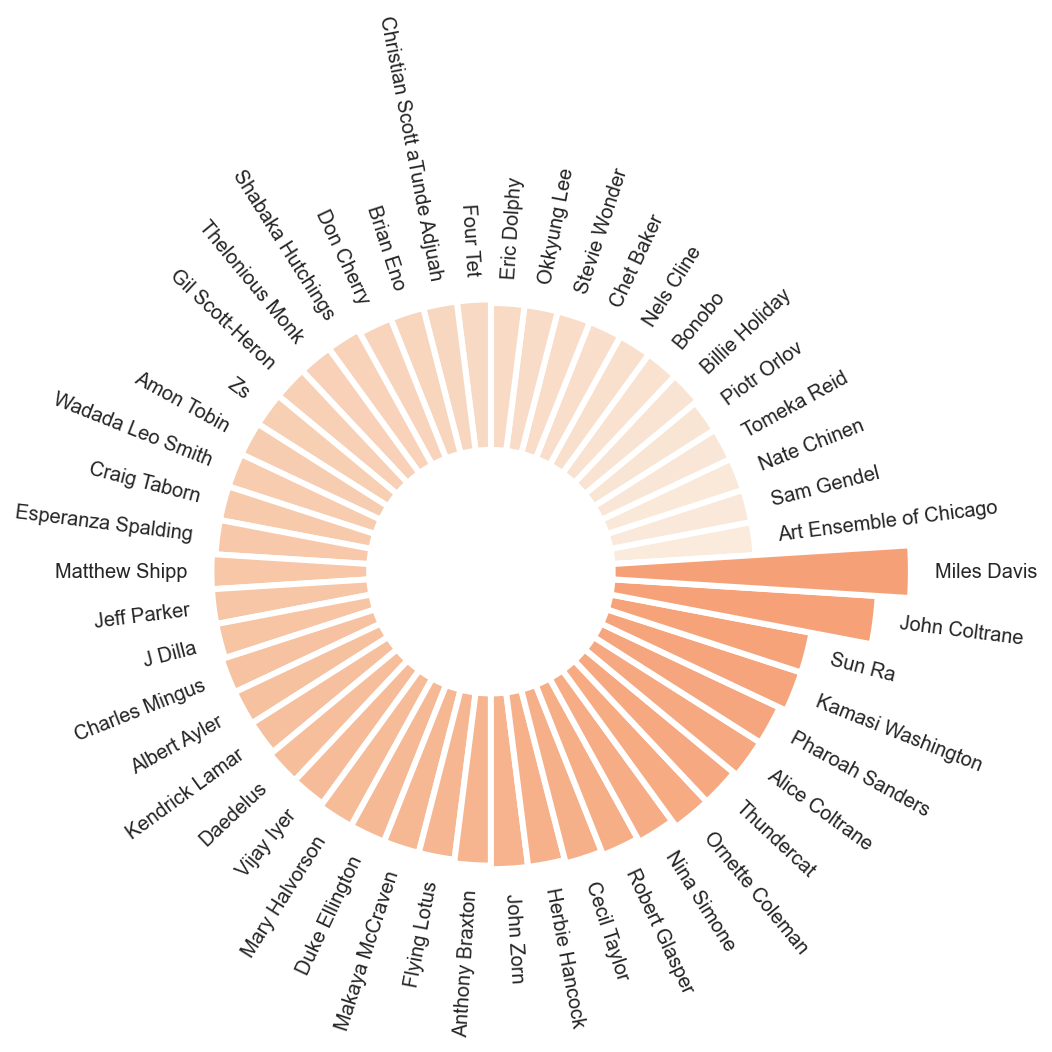

In [2919]:
# import pandas for data wrangling
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors

my_cmap=sns.cm.rocket_r  #cmap= sns.cubehelix_palette()
#my_cmap = plt.get_cmap("magma")#tab20c
# Reorder the dataframe
dfment = dfment.sort_values(by=['Count'])

# initialize the figure
plt.figure(figsize=(10,8))
ax = plt.subplot(111, polar=True)

# fig=plt.figure()
# fig.set_figheight(20)
# fig.set_figwidth(20)

plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 100
lowerLimit = 20
labelPadding = 4

# Compute max and min in the dataset
max = dfment['Count'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * dfment.Count + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(dfment.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(dfment.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=3, 
    edgecolor="white",
    #color="#61a4b2",
    color=my_cmap.colors,
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, dfment["Word"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 
    
#plt.tight_layout()
plt.savefig('../img/circbar_top_mentions.png')  
plt.savefig('../img/circbar_top_mentions.svg')  

**Also created separate script for above (def_circbar.py)**

## Add Topic Genre - above sub genres

**Using DF above - pivot/transpose the genres into a list per album**

In [1589]:
# change revID to str for aggregation
df_genre_list = final_database.copy()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1590]:
df_genre_list['revIDstr'] = df_genre_list['revID'].astype(str) # which will by default set the length to the max len it encounters
df_genre_list["Keyword"].fillna("No Genre", inplace = True) 
df_genre_list["Count"].fillna(0,inplace=True)
df_genre_list["Subject"].fillna("Stats",inplace=True)

#df_genre_list['revIDstr'] = df_genre_list['revID'].astype('|S') # which will by default set the length to the max len it encounters
#final_database['revID'] = final_database['revID'].astype(str) #.astype(str)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Group by to put genre into list**

In [1593]:
df_genre_list2 = df_genre_list.groupby('revIDstr').Keyword.agg([('count', 'count'), ('Keyword', ', '.join)])
df_genre_list2.head(3)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count,Keyword
revIDstr,,
0.0,5,"jazz , free jazz , cloud rap , chiptune , ambi..."
1.0,5,"afrobeat , jazz , funk , hiphop , musical"
10.0,4,"jazz , pop , gospel , musical"


In [1597]:
df_genre_list2.columns

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['count', 'Keyword'], dtype='object')

In [1598]:
df_genre_list2["revID"] = df_genre_list2.index.astype(float)
df_genre_list2

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count,Keyword,revID
revIDstr,,,
0.0,5,"jazz , free jazz , cloud rap , chiptune , ambi...",0.0
1.0,5,"afrobeat , jazz , funk , hiphop , musical",1.0
10.0,4,"jazz , pop , gospel , musical",10.0
100.0,5,"vocal jazz , jazz , musical , club , house",100.0
101.0,2,"instrumental , blues",101.0
...,...,...,...
95.0,10,"jazz , classical , musical , opera , avantgard...",95.0
96.0,7,"jazz , free jazz , dub , hiphop , soca , grime...",96.0
97.0,5,"hiphop , classical , jazz , gospel , avantgarde",97.0


### Output files to work with in Streamlit

**Wide DF (album level)**

In [1602]:
# merge album level - genres strings into album level with genre flags
df_genre_list_mrg=df_long.merge(df_genre_list2, on='revID', how='left')
df_genre_list_mrg.head(2)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,revID,Subject,Keyword_x,Count,artist,album,score,genre,review,othercat2,...,review_clean,othercat_clean,artist_clean,album_clean,revdate,review_lem,review_clean2,totalwords,count,Keyword_y
0,0.0,Stats,jazz,2,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",...,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,fresh bread,2021-03-04,fiftytwo track deep this archival compendium m...,fiftytwo tracks deep this archival compendium ...,600,5,"jazz , free jazz , cloud rap , chiptune , ambi..."
1,0.0,Stats,free jazz,1,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",...,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,fresh bread,2021-03-04,fiftytwo track deep this archival compendium m...,fiftytwo tracks deep this archival compendium ...,600,5,"jazz , free jazz , cloud rap , chiptune , ambi..."


In [1611]:
# Drop subject, keyword x and count
df_genre_list_mrg.drop(['Subject','Keyword_x','Count'],axis=1,inplace=True)

# dropping duplicate values 
df_genre_list_nodup = df_genre_list_mrg.drop_duplicates(subset='revID',keep='first') 
  
# length after removing duplicates 
df_genre_list_nodup.shape

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(624, 18)

In [1612]:
df_genre_list_nodup.head(2)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,revID,artist,album,score,genre,review,othercat2,best,review_clean,othercat_clean,artist_clean,album_clean,revdate,review_lem,review_clean2,totalwords,count,Keyword_y
0,0.0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,fresh bread,2021-03-04,fiftytwo track deep this archival compendium m...,fiftytwo tracks deep this archival compendium ...,600,5,"jazz , free jazz , cloud rap , chiptune , ambi..."
5,1.0,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",femi kuti / made kuti,legacy +,2021-02-20,on the duo ’s generationspanne double album fe...,on the duo s generationspanning double album f...,493,5,"afrobeat , jazz , funk , hiphop , musical"


**Get all sub-genres as columns**

In [1613]:
df_genre_bools =df_long[['revID','Keyword','Count']]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1614]:
df_genre_bools.fillna(0,inplace=True)
df_genre_bools['Count']=df_genre_bools['Count'].astype(str).astype(int)
df_genre_bools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4040 entries, 0 to 4039
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   revID    4040 non-null   float64
 1   Keyword  4040 non-null   object 
 2   Count    4040 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 126.2+ KB


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Group by and Pivot to make genres columns**

In [1615]:
df_genre_bools_list=pd.pivot_table(df_genre_bools, index = 'revID', values = 'Count', columns = 'Keyword', aggfunc = 'sum')
df_genre_bools_list.fillna(0,inplace=True)
df_genre_bools_list.head(2)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Keyword,0,acid house,acid jazz,acid rock,acoustic blues,afrobeat,ambient,ambient techno,americana,art rock,...,trap,trip hop,turntablism,uk garage,underground hiphop,vocal house,vocal jazz,waltz,west coast hiphop,western swing
revID,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1664]:
# Drop cols 0
df_genre_bools_list.drop([0],axis=1,inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Merge with wide file list**

In [2503]:
df_genre_stream_wide=df_genre_bools_list.merge(df_genre_list_nodup, on='revID', how='left')

### Output wide file to csv

In [2504]:
cols = df_genre_stream_wide.columns.tolist()
cols = cols[-17:] + cols[:-17]
cols

['artist',
 'album',
 'score',
 'genre',
 'review',
 'othercat2',
 'best',
 'review_clean',
 'othercat_clean',
 'artist_clean',
 'album_clean',
 'revdate',
 'review_lem',
 'review_clean2',
 'totalwords',
 'count',
 'Keyword_y',
 'revID',
 'acid house ',
 'acid jazz ',
 'acid rock ',
 'acoustic blues ',
 'afrobeat ',
 'ambient ',
 'ambient techno ',
 'americana ',
 'art rock ',
 'avantgarde ',
 'avantgarde jazz ',
 'avantgarde metal ',
 'avantprog ',
 'ballad ',
 'baroque ',
 'beat music ',
 'bebop ',
 'big band ',
 'big beat ',
 'black metal ',
 'bluegrass ',
 'blues ',
 'bolero ',
 'boogiewoogie ',
 'bossa nova ',
 'bounce ',
 'breakbeat ',
 'breaks ',
 'britpop ',
 'broken beat ',
 'calypso ',
 'celtic ',
 'chillout ',
 'chiptune ',
 'chopped and screwed ',
 'classic jazz ',
 'classic rock ',
 'classical ',
 'cloud rap ',
 'club ',
 'comedy ',
 'conscious hiphop ',
 'contemporary classical ',
 'contemporary jazz ',
 'cool jazz ',
 'country ',
 'country blues ',
 'cumbia ',
 'cyberpun

In [2505]:
df_genre_stream_wide = df_genre_stream_wide[cols]

In [2506]:
df_genre_stream_wide.head(2)

,artist,album,score,genre,review,othercat2,best,review_clean,othercat_clean,artist_clean,...,trap,trip hop,turntablism,uk garage,underground hiphop,vocal house,vocal jazz,waltz,west coast hiphop,western swing
0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",femi kuti / made kuti,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2507]:
# There are 2 cols that need to be dropped. the index and a column full of zeros
df_genre_stream_wide.rename(columns={'Keyword_y': 'Keyword'},inplace=True)
df_genre_stream_wide['year'] = df_genre_stream_wide['revdate'].dt.year
df_genre_stream_wide.set_index('artist')
df_genre_stream_wide.to_csv(r'../data/df_genre_stream_wide.csv')

**Wide mini file - Create DF with album and keywords**

In [2508]:
# dont forget to remove the index column when outputting
df_small_wide= df_genre_stream_wide[['artist','album','Keyword']]
df_small_wide.head(2)

,artist,album,Keyword
0,Sam Gendel,Fresh Bread,"jazz , free jazz , cloud rap , chiptune , ambi..."
1,Femi Kuti / Made Kuti,Legacy +,"afrobeat , jazz , funk , hiphop , musical"


In [2509]:
df_small_wide.to_csv(r'../data/df_stream_wide_sm.csv')

### Output long file to csv

In [1760]:
# Drop subject (stats) and rearrange order.
# Set artist as index
df_genre_stream_long= df_long.drop(['Subject'],axis=1)
df_genre_stream_long.rename(columns={'Count': 'count'},inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1761]:
longcols = df_genre_stream_long.columns.tolist()
longcols = longcols[-15:] + longcols[:-15]
longcols

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['artist',
 'album',
 'score',
 'genre',
 'review',
 'othercat2',
 'best',
 'review_clean',
 'othercat_clean',
 'artist_clean',
 'album_clean',
 'revdate',
 'review_lem',
 'review_clean2',
 'totalwords',
 'revID',
 'Keyword',
 'count']

In [1762]:
df_genre_stream_long = df_genre_stream_long[longcols]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2501]:
df_genre_stream_long['year'] = df_genre_stream_long['revdate'].dt.year

In [2502]:
df_genre_stream_long.set_index('artist')
df_genre_stream_long.to_csv(r'../data/df_genre_stream_long.csv')

## Other Topics and sliders/buttons
- Instruments (based on topic modeling, nouns??)
- Emotions (see what to keep based on lexicon)
- Sentiment (if not already parsed from above)
- Mentions? this could be in EDA

**Additional**
- link to artist and song
- image of top artist / album
- network graphing

## Add Emotions

In [1783]:
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer

import time
import pandas as pd
import requests

from tqdm import tqdm

def text_emotion(df, column):
    '''
    Takes a DataFrame and a specified column of text and adds 10 columns to the
    DataFrame for each of the 10 emotions in the NRC Emotion Lexicon, with each
    column containing the value of the text in that emotions
    INPUT: DataFrame, string
    OUTPUT: the original DataFrame with ten new columns
    '''

    df_emo = df.copy()

    filepath = ('../data/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t')
    emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()
    emotions = emolex_words.columns.drop('word')
    emo_df = pd.DataFrame(0, index=df.index, columns=emotions)

    stemmer = SnowballStemmer("english")

    
    book = ''
    chapter = ''
    
    with tqdm(total=len(list(df_emo.iterrows()))) as pbar:
        for i, row in df_emo.iterrows():
            pbar.update(1)
            document = word_tokenize(df_emo.loc[i][column])
            for word in document:
                word = stemmer.stem(word.lower())
                emo_score = emolex_words[emolex_words.word == word]
                if not emo_score.empty:
                    for emotion in list(emotions):
                        emo_df.at[i, emotion] += emo_score[emotion]

    df_emo = pd.concat([df_emo, emo_df], axis=1)

    return df_emo

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1784]:
df_emo2 = text_emotion(df, 'review_lem')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 624/624 [16:39<00:00,  1.60s/it]


In [1775]:
df_emo2.head(2)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,revID,artist,album,score,genre,review,othercat2,best,review_clean,othercat_clean,...,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",...,4,17,1,6,8,9,16,8,7,9
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",...,8,10,6,6,9,13,34,10,9,16


### count words and standardize the emotion counts

In [1778]:
from nltk import tokenize
df_emo3 = df_emo2.copy()
df_emo3['word_count'] = df_emo3['review_lem'].apply(tokenize.word_tokenize).apply(len)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1779]:
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1780]:
for emotion in emotions:
    df_emo3[emotion] = df_emo3[emotion] / df_emo3['word_count']

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1781]:
df_emo3.head(2)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,revID,artist,album,score,genre,review,othercat2,best,review_clean,othercat_clean,...,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,word_count
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",...,0.026034,0.001531,0.009188,0.012251,0.013783,0.024502,0.012251,0.010720,0.013783,653
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",...,0.017544,0.010526,0.010526,0.015789,0.022807,0.059649,0.017544,0.015789,0.028070,570


In [1782]:
df_emo3.describe()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,revID,score,best,totalwords,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,word_count
count,624.000000,615.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000
mean,311.500000,7.428618,0.070513,710.939103,0.009055,0.021551,0.005826,0.011070,0.018480,0.024874,0.043683,0.016039,0.009816,0.021585,741.918269
std,180.277564,1.157300,0.256215,289.938621,0.005644,0.007659,0.004830,0.006807,0.007609,0.010078,0.011772,0.007478,0.005099,0.007994,311.733791
min,0.000000,1.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
25%,155.750000,7.000000,0.000000,537.500000,0.005323,0.016380,0.002654,0.006534,0.013319,0.018322,0.036972,0.011045,0.006751,0.016302,563.000000
50%,311.500000,7.600000,0.000000,645.000000,0.008024,0.021173,0.004912,0.010050,0.017787,0.023715,0.043690,0.015038,0.009126,0.021167,671.000000
75%,467.250000,8.000000,0.000000,815.250000,0.011761,0.026029,0.007683,0.014229,0.022781,0.030600,0.051282,0.019881,0.012369,0.026405,849.500000
max,623.000000,10.000000,1.000000,2157.000000,0.040073,0.058407,0.049180,0.063752,0.043517,0.072860,0.088477,0.054645,0.030756,0.057181,2308.000000


### Idea - to use emotions either as levers or simply descriptive attributes of an albums review (radars or otherwise)

## MERGE: Wide and Long DF + emotion 

In [1799]:
# keep only emotion columsn
df_emo_mrg = df_emo3[['revID','anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]
df_emo_mrg.columns

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['revID', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative',
       'positive', 'sadness', 'surprise', 'trust'],
      dtype='object')

In [2510]:
df_genre_stream_emo_long = df_genre_stream_long.merge(df_emo_mrg,on='revID', how='left')

In [2511]:
df_genre_stream_emo_wide = df_genre_stream_wide.merge(df_emo_mrg,on='revID', how='left')

### output to csv

In [2512]:
# Long file
df_genre_stream_emo_long.set_index('artist')
df_genre_stream_emo_long.to_csv(r'../data/df_genre_stream_emo_long.csv')

In [2513]:
# Wide file
df_genre_stream_emo_wide.set_index('artist')
df_genre_stream_emo_wide.to_csv(r'../data/df_genre_stream_emo_wide.csv')

### Data Viz - Emotion - Polar Chart

In [2475]:
# Transpose per artist
df_emoviz = df_genre_stream_emo_wide[['revID','anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]
df_emoviz = df_emoviz.head(1)
print(df_emoviz)

   revID     anger  anticipation   disgust      fear       joy  negative  \
0    0.0  0.006126      0.026034  0.001531  0.009188  0.012251  0.013783   

   positive   sadness  surprise     trust  
0  0.024502  0.012251   0.01072  0.013783  


In [2476]:
# transpose
df_emoviz_T = df_emoviz.T
df_emoviz_T = df_emoviz_T.iloc[1:]
df_emoviz_T.rename(columns={0:'emo_score'}, inplace=True )
df_emoviz_T.index.name = 'emotions'
df_emoviz_T

,emo_score
emotions,
anger,0.006126
anticipation,0.026034
disgust,0.001531
fear,0.009188
joy,0.012251
negative,0.013783
positive,0.024502
sadness,0.012251
surprise,0.010720


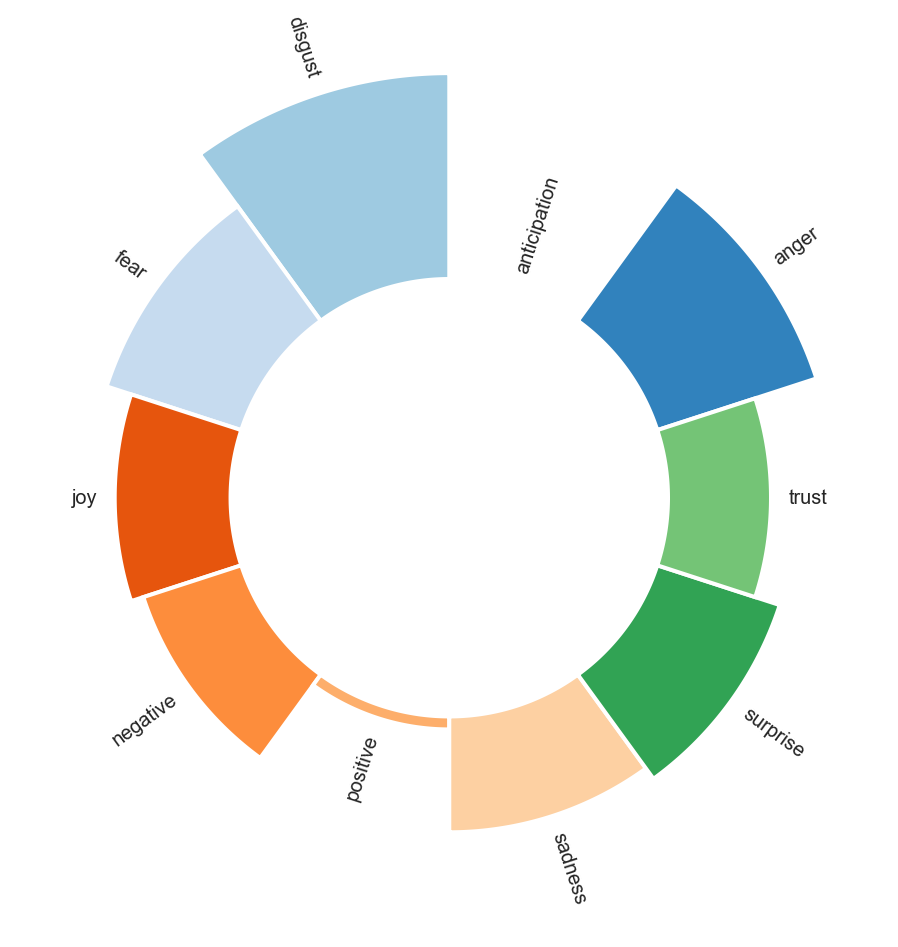

In [2496]:
my_cmap = plt.get_cmap("tab20c")#tab20c

# initialize the figure
plt.figure(figsize=(10,8))
ax = plt.subplot(111, polar=True)
plt.axis('off')

upperLimit = 100
lowerLimit = 50


# Compute max and min in the dataset
max = df_emoviz_T['emo_score'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * df_emoviz_T.emo_score + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df_emoviz_T.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(df_emoviz_T.index)+1))
angles = [element * width for element in indexes]

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    #color="#61a4b2",
    color=my_cmap.colors,
)

# little space between the bar and the label
labelPadding = 4

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df_emoviz_T.index):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 

## Topic Modeling PART II (NOUNS - Review Instrumentation)

In [1810]:
df_rev2 = df_genre_stream_emo_wide['review_lem']
df_rev2.head(3)

0    fiftytwo track deep this archival compendium m...
1    on the duo ’s generationspanne double album fe...
2    these live set between the saxophonist and pia...
Name: review_lem, dtype: object

### We want to use NOUNS only for topics since we have emotions above 

In [1920]:
# Makes sense to add words like 'jazz' to stopwords
stopadd = ['fall','series','material','set','nt','really','bad','disc','ca','smith','jame',
           'even','anyone','probably','know','think','server','cache','service','details','zs','fire','cachelgb',
           'jazz','player', 'scene','space',
          'parker','william',
          'sun','ra']
my_stop_words.extend(stopadd)

### POS tagging

In [1812]:
# Let's create a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] in ('NN','NNS') # == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [1821]:
df_rev_nouns = pd.DataFrame(df_genre_stream_emo_wide['review_lem'].apply(nouns))
df_rev_nouns.head(2)

,review_lem
0,track deep compendium catchall fact chance hoo...
1,duo ’ s generationspanne album fela lead spiri...


### NMF Model

In [1906]:
# Create a function to model topics using NMF
def nmf_it(data, mindf, maxdf, n_components, n_top_words, stop_list):
    '''Fits an NMF model and prints top words for each topic.
    
    Parameters:
        data: DataFrame/Series containing only raw texts
        n_samples: number of texts to sample from data
        n_features: length of TF-IDF vectors to calculate
        n_components: number of topics to model
        n_top_words: number of words to print for each topic, ranked by
            frequency
        stop_list: your list of stopwords to remove
    '''
    
    # Get sample of data
    #data_samples = data.sample(n_samples, random_state=1)
    
    # Instantiate and fit TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(max_df=maxdf, min_df=mindf,
                                       # max_features=n_features,
                                       stop_words=my_stop_words)

    tfidf = tfidf_vectorizer.fit_transform(data) #(data_samples)
    
    # Fit the NMF model
    nmf = NMF(n_components=n_components, random_state=1, alpha=.1, 
              l1_ratio=.5).fit(tfidf)

    # View top words for each topic
    print("\nTopics in NMF model (Frobenius norm):")
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    
    for topic_idx, topic in enumerate(nmf.components_):
        message = "Topic #{}: ".format(topic_idx+1)
        message += " ".join([tfidf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    
    return tfidf, nmf

In [1963]:
# View top 10 words for 20 topics
tfidf, nmf = nmf_it(df_rev_nouns['review_lem'],0.07,0.80,8,10,my_stop_words)


Topics in NMF model (Frobenius norm):
Topic #1: group piece piano sound solo composition track pianist note melody
Topic #2: hiphop beat track sample dj drum mix rap production bass
Topic #3: guitar rock noise track record guitarist sound drum solo thing
Topic #4: record man voice singer life soul love day people world
Topic #5: studio session record version concert performance recording reissue release show
Topic #6: trio drummer pace guitarist loop moment section record line group
Topic #7: film soundtrack score world game cut age lp sort percussion
Topic #8: duo session return pair collaboration improvise country touch side control


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'skip', 'staff', 'sunday', 'tracks', 'video'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [1964]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [1968]:
# CHANGE PARAMS if you need to
# Vectorize the text sample
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.06,
                                   stop_words=my_stop_words)

tfidf = tfidf_vectorizer.fit_transform(df_rev_nouns['review_lem'])

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'skip', 'staff', 'sunday', 'tracks', 'video'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [1969]:
# Instantiate the KMeans model and visualizer
kmeans = KMeans(random_state=1)
visualizer = KElbowVisualizer(kmeans, k=(5, 20), metric='silhouette')

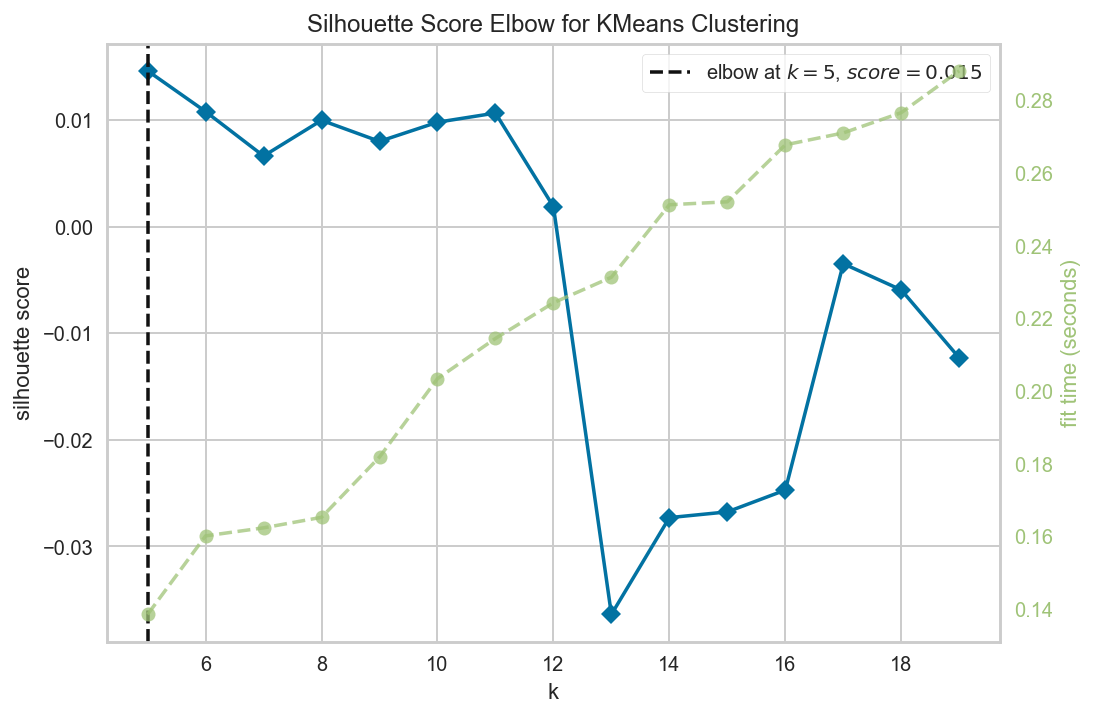

In [1970]:
# Fit the visualizer and plot the results
visualizer.fit(tfidf)       
visualizer.show(outpath='topics_fin.png', dpi=300)

### Try Nouns only @ k=5

In [1971]:
tfidf, nmf = nmf_it(df_rev_nouns['review_lem'],0.15,0.65,5,10,my_stop_words)


Topics in NMF model (Frobenius norm):
Topic #1: piece piano solo note studio pianist part composition performance session
Topic #2: beat hiphop sample voice soul production funk drum thing producer
Topic #3: guitar rock noise drum solo melody thing something play percussion
Topic #4: trio drummer section moment line tone bassist title feel horn
Topic #5: group debut moment member saxophonist percussion tune rock composition performance


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'skip', 'staff', 'sunday', 'tracks', 'video'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


**See some topics/genres emerge. Try LDA and see if any better. We may have to resort to selecting key words to get subgenres**

### LDA model

In [1854]:
# Import countVectorizer and LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation    

In [1855]:
def lda_it(data,mindf,maxdf,n_components,n_top_words,stop_list):
    '''Fits an LDA model and prints top words for each topic.
    
    Parameters:
        data: DataFrame/Series containing only raw texts
        n_samples: number of texts to sample from data
        n_features: length of TF-IDF vectors to calculate
        n_components: number of topics to model
        n_top_words: number of words to print for each topic, ranked by
            frequency
        stop_list: your list of stopwords to remove
    '''
        
    
    # Get sample of data
    #data_samples = data.sample(n_samples, random_state=1)
    
    # Instantiate and fit TfidfVectorizer
    count_vectorizer = CountVectorizer(max_df=maxdf, min_df=mindf,                                       
                                       stop_words=my_stop_words)

    counts = count_vectorizer.fit_transform(data)
    
    # Fit the LDA model
    lda = LatentDirichletAllocation(n_components=n_components, 
                                    max_iter=5,                                    
                                    random_state=42).fit(counts)

    # View top words for each topic
    print("\nTopics in LDA model (Frobenius norm):")
    counts_feats = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(lda.components_):
        message = "Topic #{}: ".format(topic_idx+1)
        message += " ".join([counts_feats[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    
    return counts, lda

In [1859]:
lda_it(df_rev_nouns['review_lem'],0.10,0.80, 10, 10, my_stop_words)


Topics in LDA model (Frobenius norm):
Topic #1: jazz piano piece record pianist note track composition sound group
Topic #2: track guitar record sound piece melody noise solo something title
Topic #3: record jazz voice soul love track singer life day history
Topic #4: film man soundtrack city world life home sound sun blue
Topic #5: jazz record sound bass track drum tune funk rhythm session
Topic #6: track sample hiphop beat record mix sound guitar rock thing
Topic #7: jazz group record performance solo player sound play guitarist drummer
Topic #8: jazz trumpet sound record drum player track city improvisation percussion
Topic #9: track record sound production something duo house beat bass release
Topic #10: jazz sound track group record trio piano melody moment bass


(<624x234 sparse matrix of type '<class 'numpy.int64'>'
 	with 28256 stored elements in Compressed Sparse Row format>,
 LatentDirichletAllocation(max_iter=5, random_state=42))

## TOPIC MODEL - NMF Selection @ 8 topics (min=0.06, max=0.80)

## NMF Doc Topics for actual topics


## Doc_Topic Matrix

In [1922]:
from gensim.corpora.dictionary import Dictionary

def vectorize_vis(data, min_df,max_df):
    vec = TfidfVectorizer(stop_words=my_stop_words, min_df=min_df, max_df=max_df) #, ngram_range=(1, 3)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    dictionary = Dictionary([feature_names])
    
    return doc_word, feature_names, id2word, dictionary

In [1923]:
def nmf_dt(doc_word, feature_names, num_topics):
    model = NMF(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))
    return model, doc_topic

In [1924]:
# convert for doc topic
df_nouns = df_rev_nouns["review_lem"]

In [1972]:
doc_word, feature_names, id2word, dictionary = vectorize_vis(df_nouns, 0.060,0.80)

nmf_model, doc_topic = nmf_dt(doc_word, feature_names, 8)


Topic  0
piano, piece, composition, pianist, sound, solo, note, quartet, trumpet, melody

Topic  1
beat, hiphop, track, sample, dj, drum, mix, rap, production, bass

Topic  2
guitar, rock, sound, record, track, noise, guitarist, melody, solo, drum

Topic  3
voice, man, life, singer, record, love, soul, people, day, world

Topic  4
metal, death, riff, fusion, saxophone, eye, drum, part, drummer, decade

Topic  5
studio, record, session, performance, version, tune, concert, box, release, recording

Topic  6
group, trio, drummer, guitarist, member, moment, saxophonist, cover, bassist, debut

Topic  7
film, soundtrack, duo, score, world, percussion, earth, cut, game, act


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'skip', 'staff', 'sunday', 'tracks', 'video'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


## Bring topics to DF

In [1974]:
df_emo_top_wide = df_genre_stream_emo_wide.copy() #pd.DataFrame(df_genre_stream_emo_wide)

In [1987]:
doc_topic

array([[0.        , 0.12400273, 0.11249688, ..., 0.06187765, 0.03314888,
        0.00273213],
       [0.02567505, 0.05363457, 0.        , ..., 0.        , 0.00941043,
        0.02064501],
       [0.03620366, 0.        , 0.        , ..., 0.06946644, 0.        ,
        0.        ],
       ...,
       [0.        , 0.0292272 , 0.00020809, ..., 0.        , 0.00067567,
        0.03573727],
       [0.01036094, 0.19297741, 0.00819807, ..., 0.        , 0.        ,
        0.        ],
       [0.00456391, 0.06759881, 0.00790643, ..., 0.02923731, 0.        ,
        0.        ]])

In [2522]:
df_emo_top_wide['topic']=doc_topic.argmax(axis=1)

In [2523]:
df_emo_top_wide.head(3)

,artist,album,score,genre,review,othercat2,best,review_clean,othercat_clean,artist_clean,...,disgust,fear,joy,negative,positive,sadness,surprise,trust,topic,topic_label
0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,...,0.001531,0.009188,0.012251,0.013783,0.024502,0.012251,0.010720,0.013783,1,"2: beat, hiphop, track, sample, dj, drum, mix,..."
1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",femi kuti / made kuti,...,0.010526,0.010526,0.015789,0.022807,0.059649,0.017544,0.015789,0.028070,3,"4: horns, voice, singer, life, love, soul, peo..."
2,Archie Shepp / Jason Moran,Let My People Go,7.5,Jazz,These live sets between the saxophonist and pi...,"Archie Shepp, Jason Moran, Madison Bloom, ...",0,these live sets between the saxophonist and pi...,"archie shepp, jason moran, madison bloom, ...",archie shepp / jason moran,...,0.001359,0.009511,0.024457,0.016304,0.044837,0.025815,0.005435,0.016304,3,"4: horns, voice, singer, life, love, soul, peo..."


In [2524]:
def label_top(row):
    if row['topic'] == 0 :
        return '1: piano, piece, composition,quartet, trumpet, solo, melody'
    elif row['topic'] == 1 :
        return '2: beat, hiphop, track, sample, dj, drum, mix, rap, bass, production'
    elif row['topic'] == 2 :
        return '3: guitar, rock, sound, noise, guitarist, solo, melody, drum'
    elif row['topic'] == 3 :
        return '4: horns, voice, singer, life, love, soul, people, day, world'    
    elif row['topic'] == 4 :
        return '5: experiemental, metal, death, riff, fusion, saxophone, eye, drum'
    elif row['topic'] == 5 :
        return '6: classic, studio, record, session, performance, version, concert, tune'
    elif row['topic'] == 6 :
        return '7: fusion, group, member, guitarist, saxophonist, cover'
    elif row['topic'] == 7 :
        return '8: cinematic, film, soundtrack, score, world, cut, earth, percussion'
    
    return 'Other'

In [2525]:
df_emo_top_wide.apply(lambda row: label_top(row), axis=1)

0      2: beat, hiphop, track, sample, dj, drum, mix,...
1      4: horns, voice, singer, life, love, soul, peo...
2      4: horns, voice, singer, life, love, soul, peo...
3      1: piano, piece, composition,quartet, trumpet,...
4      3: guitar, rock, sound, noise, guitarist, solo...
                             ...                        
619    4: horns, voice, singer, life, love, soul, peo...
620    2: beat, hiphop, track, sample, dj, drum, mix,...
621    4: horns, voice, singer, life, love, soul, peo...
622    2: beat, hiphop, track, sample, dj, drum, mix,...
623    4: horns, voice, singer, life, love, soul, peo...
Length: 624, dtype: object

In [2526]:
df_emo_top_wide['topic_label'] = df_emo_top_wide.apply(lambda row: label_top(row), axis=1)
df_emo_top_wide['year'] = df_emo_top_wide['revdate'].dt.year

**output wide to CSV**

In [2534]:
df_emo_top_wide.to_csv('../data/df_emo_top_wide.csv')

In [2535]:
df_emo_top_wide.topic_label.value_counts()

2: beat, hiphop, track, sample, dj, drum, mix, rap, bass, production        136
1: piano, piece, composition,quartet, trumpet, solo, melody                  99
4: horns, voice, singer, life, love, soul, people, day, world                92
3: guitar, rock, sound, noise, guitarist, solo, melody, drum                 86
7: fusion, group, member, guitarist, saxophonist, cover                      78
6: classic, studio, record, session, performance, version, concert, tune     70
8: cinematic, film, soundtrack, score, world, cut, earth, percussion         44
5: experiemental, metal, death, riff, fusion, saxophone, eye, drum           19
Name: topic_label, dtype: int64

## Get all named entities as columns

In [2759]:
df_names_wide =df_emo_top_wide[['revID','othercat2']]

In [2760]:
df_names_wide.head(1)

,revID,othercat2
0,0.0,"Sam Gendel, Jay Balfour, Sam Gendel, cover..."


In [2762]:
df_names_long2=df_names_long.groupby(['revID', 'othercat2']).size().reset_index(name='names_counts')
df_names_long2

,revID,othercat2,names_counts
0,0.0,4444,1
1,0.0,Champs Élysées,1
2,0.0,Jay Balfour,1
3,0.0,Ocarina of Time,1
4,0.0,Sam Gendel,2
...,...,...,...
3947,622.0,Rap,1
3948,622.0,Roots Manuva,1
3949,623.0,Coldcut,1
3950,623.0,Electronic,1


In [2763]:
#test.groupby(['revID','othercat2']).sum()
df_names_long3=pd.pivot_table(df_names_long2, index = 'revID', values = 'names_counts', columns = 'othercat2', aggfunc = 'sum')
df_names_long3.fillna(0,inplace=True)
del df_names_long3['']
#test2.drop((0.0),inplace=True)
df_names_long3.head(2)

othercat2,+2,000 hours,1,1.4 million,100-year anniversary,10cc,15 other musicians,1970),1972 hit,1980s cartoon,...,working with,writing about her experiences,writing intricate songs for others to sing.,writing music,wrote,yanggeum,Ó,Ólafur Arnalds,ü,’90s performance
revID,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2764]:
# testing
rslt_df = df_names_long3[['Sam Gendel']][df_names_long3['Sam Gendel'] >=1] 
rslt_df

othercat2,Sam Gendel
revID,
0.0,2.0
27.0,1.0
50.0,1.0
107.0,1.0
146.0,1.0


### Merge named entity counts to wide file

In [2777]:
df_emo_top_wide_nm = df_emo_top_wide.merge(df_names_long3,on='revID',how='left')
df_emo_top_wide_nm.rename(columns={'album_x': 'album'} , inplace=True)
df_emo_top_wide_nm.set_index('artist')
df_emo_top_wide_nm.to_csv('../data/df_emo_top_wide_nm.csv')

### Merge named entity counts to long file

In [2778]:
df_genre_stream_emo_long_nm=df_genre_stream_emo_long.merge(df_names_long3,on='revID',how='left')
# merge below and output

### Merge to long file

**output long to CSV**

**Merge in Genre mapping**

In [2528]:
genre_map= pd.read_csv('../data/genre_map.csv')
genre_map

,Keyword,subgenre
0,jazz,jazz
1,musical,jazz
2,rock,rock/metal
3,funk,funk/disco
4,pop,pop/r&b
...,...,...
220,rap rock,hiphop/rap
221,progressive rock,rock/metal
222,boogiewoogie,funk/disco
223,uk garage,rock/metal


In [2784]:
# merge the topic onto the long file
df_emo_top_long = df_genre_stream_emo_long_nm.copy() #pd.DataFrame(df_genre_stream_emo_wide)

In [2785]:
df_emo_top_long = df_emo_top_long.merge(genre_map,on='Keyword',how='left')
df_emo_top_long.rename(columns={'Keyword': 'subgenre2'} , inplace=True)

In [2786]:
dfwide= df_emo_top_wide[['revID','topic','topic_label']]
df_emo_top_long_nm = df_emo_top_long.merge(dfwide,on='revID',how='left')
df_emo_top_long_nm.rename(columns={'album_x': 'album'} , inplace=True)
df_emo_top_long_nm.set_index('artist')
df_emo_top_long_nm.head(2)

,artist,album,score,genre,review,othercat2,best,review_clean,othercat_clean,artist_clean,...,writing music,wrote,yanggeum,Ó,Ólafur Arnalds,ü,’90s performance,subgenre,topic,topic_label
0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jazz,1,"2: beat, hiphop, track, sample, dj, drum, mix,..."
1,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jazz,1,"2: beat, hiphop, track, sample, dj, drum, mix,..."


In [2787]:
df_emo_top_long_nm.to_csv('../data/df_emo_top_long_nm.csv')

## HEatmap of full genre over time

In [2853]:
df_emo_limited=df_emo_top_long_nm[['subgenre','count','revdate']]

In [2855]:
df_emo_limited['year'] = df_emo_limited['revdate'].dt.year
df_emo_limited.drop(['revdate'],axis=1,inplace=True)

In [2829]:
df_emo_limited.head(2)

,subgenre,count,year
0,jazz,2,2021.0
1,jazz,1,2021.0


In [2830]:
df_emo_limited.fillna(0,inplace=True)
df_emo_limited['count']=df_emo_limited['count'].astype(str).astype(int)
df_emo_limited.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4040 entries, 0 to 4039
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   subgenre  4040 non-null   object 
 1   count     4040 non-null   int64  
 2   year      4040 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 126.2+ KB


**Group by and Pivot to make genres columns**

In [2831]:
# Gropu by year
x=df_emo_limited.groupby(['year']).sum()

In [2834]:
genre_time_emo=pd.pivot_table(df_emo_limited, index = 'year', values = 'count', columns = 'subgenre', aggfunc = 'sum')
genre_time_emo.fillna(0,inplace=True)
genre_time_emo.drop((0.0),inplace=True)
genre_time_emo

subgenre,0,blues/soul,classical,comedy,electronic,experimental,folk/country,funk/disco,global,hiphop/rap,indiepop,jazz,latin,pop/r&b,punk,reggae,rock/metal,spokenword
year,,,,,,,,,,,,,,,,,,
1999.0,0.0,11.0,2.0,0.0,14.0,4.0,0.0,2.0,0.0,6.0,0.0,11.0,0.0,7.0,0.0,0.0,2.0,0.0
2000.0,0.0,10.0,3.0,1.0,37.0,4.0,0.0,7.0,0.0,7.0,1.0,39.0,0.0,9.0,0.0,0.0,7.0,0.0
2001.0,0.0,9.0,9.0,0.0,38.0,29.0,2.0,11.0,0.0,14.0,3.0,85.0,0.0,12.0,0.0,0.0,17.0,0.0
2002.0,0.0,21.0,6.0,1.0,79.0,18.0,14.0,21.0,3.0,47.0,6.0,196.0,1.0,26.0,1.0,2.0,33.0,5.0
2003.0,0.0,10.0,10.0,3.0,56.0,14.0,13.0,27.0,3.0,44.0,4.0,189.0,3.0,13.0,1.0,1.0,45.0,0.0
2004.0,0.0,19.0,9.0,0.0,95.0,22.0,9.0,21.0,7.0,36.0,6.0,204.0,0.0,23.0,2.0,1.0,35.0,0.0
2005.0,0.0,7.0,3.0,2.0,32.0,9.0,5.0,3.0,6.0,12.0,2.0,64.0,0.0,16.0,0.0,2.0,49.0,0.0
2006.0,0.0,13.0,2.0,0.0,44.0,8.0,6.0,5.0,1.0,14.0,4.0,63.0,0.0,17.0,3.0,1.0,22.0,0.0
2007.0,0.0,28.0,5.0,0.0,29.0,17.0,13.0,11.0,7.0,9.0,14.0,72.0,7.0,19.0,1.0,0.0,38.0,0.0


In [2835]:
# remove jazz
genre_time_emo.columns = genre_time_emo.columns.str.strip()
genre_time_emo_limited=genre_time_emo.drop('jazz',axis=1)
# transpose
genre_time_emo_T = genre_time_emo_limited.T
genre_time_emo_T = genre_time_emo_T.iloc[1:]
genre_time_emo_T

year,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,...,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0
subgenre,,,,,,,,,,,,,,,,,,,,,
blues/soul,11.0,10.0,9.0,21.0,10.0,19.0,7.0,13.0,28.0,13.0,...,6.0,8.0,2.0,12.0,19.0,17.0,50.0,27.0,66.0,2.0
classical,2.0,3.0,9.0,6.0,10.0,9.0,3.0,2.0,5.0,6.0,...,9.0,6.0,2.0,3.0,17.0,27.0,13.0,19.0,14.0,1.0
comedy,0.0,1.0,0.0,1.0,3.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
electronic,14.0,37.0,38.0,79.0,56.0,95.0,32.0,44.0,29.0,40.0,...,20.0,18.0,16.0,16.0,38.0,61.0,63.0,65.0,40.0,5.0
experimental,4.0,4.0,29.0,18.0,14.0,22.0,9.0,8.0,17.0,12.0,...,4.0,16.0,5.0,16.0,24.0,8.0,20.0,13.0,20.0,3.0
folk/country,0.0,0.0,2.0,14.0,13.0,9.0,5.0,6.0,13.0,7.0,...,3.0,0.0,0.0,4.0,10.0,0.0,15.0,21.0,27.0,0.0
funk/disco,2.0,7.0,11.0,21.0,27.0,21.0,3.0,5.0,11.0,10.0,...,5.0,4.0,3.0,7.0,24.0,21.0,21.0,14.0,30.0,2.0
global,0.0,0.0,0.0,3.0,3.0,7.0,6.0,1.0,7.0,6.0,...,0.0,1.0,0.0,0.0,2.0,2.0,12.0,7.0,13.0,4.0
hiphop/rap,6.0,7.0,14.0,47.0,44.0,36.0,12.0,14.0,9.0,22.0,...,3.0,3.0,1.0,12.0,29.0,18.0,23.0,25.0,39.0,2.0


### Data viz - heatmap of genre over time

**Take only the top 30 genres**

In [2839]:
# sum across columns
genre_time_emo_T['total_genres'] = genre_time_emo_T.sum(axis=1)

# sort by total
genre_time_emo_T_top10=genre_time_emo_T.sort_values(by=['total_genres'],ascending=False).nlargest(10, 'total_genres')

# take top 20
genre_time_emo_T_top10.drop(['total_genres'],axis=1,inplace=True)

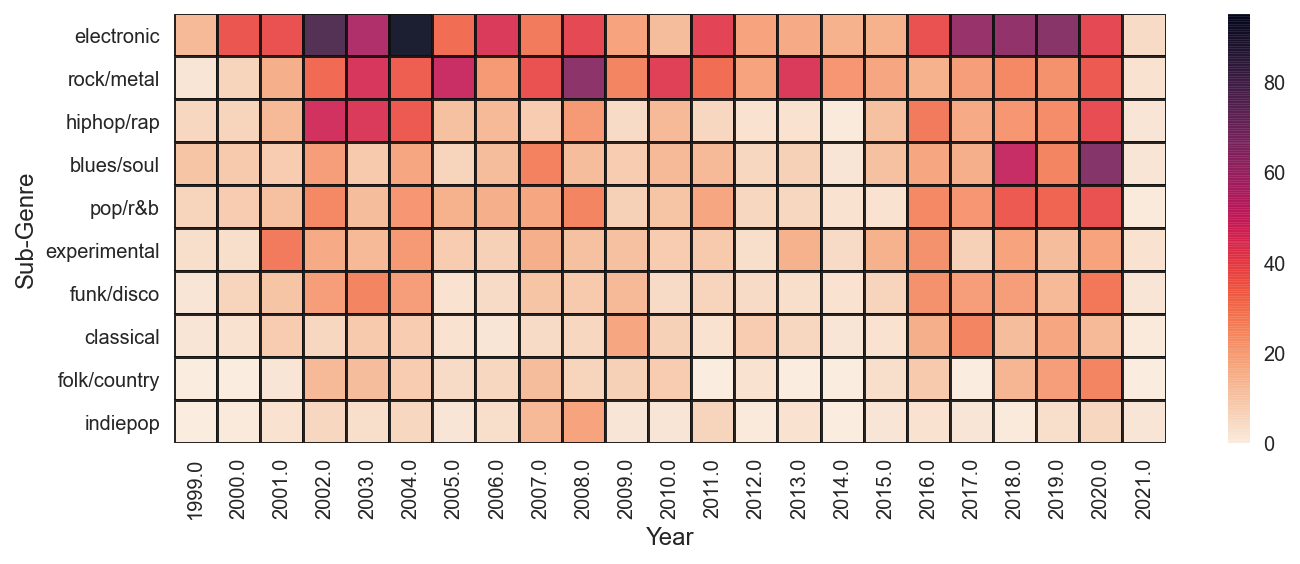

In [2902]:
gentime_df_rmv = genre_time_emo_T_top10[0:]

#x=sns.color_palette("crest", as_cmap=True)

fig, ax = plt.subplots(figsize=(10, 4))
cmap=sns.cm.rocket_r  #cmap= sns.cubehelix_palette()
#kwargs = {'alpha':.9,'linewidth':1, 'linestyle':'-', 'linecolor':'k','rasterized':False, 'edgecolor':'w', "capstyle":'projecting',}
sns.heatmap(gentime_df_rmv, cmap=cmap , **kwargs )
plt.ylabel('Sub-Genre',fontsize=12)
plt.xlabel('Year',fontsize=12)
plt.tight_layout()
plt.savefig('../img/heatmap_subgenre_10.png')
plt.savefig('../img/heatmap_subgenre_10.svg')

**Output to csv**

In [2880]:
gentime_df_rmv.to_csv('../img/heatmap_subgenre_10.png')
gentime_df_rmv.to_csv('../img/heatmap_subgenre_10.svg')

### get top 3

In [2898]:
# sort by total
genre_time_emo_T_top1=genre_time_emo_T.sort_values(by=['total_genres'],ascending=False).nlargest(3, 'total_genres')
genre_time_emo_T_top1.drop(['total_genres'],axis=1,inplace=True)
genre_time_emo_T_top1.columns
genre_time_emo_T_top1b = genre_time_emo_T_top1[[2016.0,2017.0,2018.0,2019.0,2020.0]]

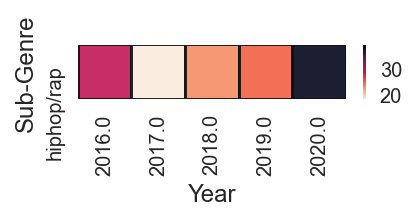

In [2901]:
gentime_df_rmv = genre_time_emo_T_top1b[2:]

#x=sns.color_palette("crest", as_cmap=True)

fig, ax = plt.subplots(figsize=(3, 0.5))
cmap=sns.cm.rocket_r  #cmap= sns.cubehelix_palette()
#kwargs = {'alpha':.9,'linewidth':1, 'linestyle':'-', 'linecolor':'k','rasterized':False, 'edgecolor':'w', "capstyle":'projecting',}
sns.heatmap(gentime_df_rmv, cmap=cmap , **kwargs )
plt.ylabel('Sub-Genre',fontsize=12)
plt.xlabel('Year',fontsize=12)
#plt.tight_layout()
plt.savefig('../img/heatmap_subgenre_3.png')
plt.savefig('../img/heatmap_subgenre_3.svg')
plt.savefig('../img/heatmap_subgenre_3.pdf')

## Topic Modeling PART III (ADJECTIVES)

### We want to use NOUNS only for topics since we have emotions above 

In [1920]:
# Makes sense to add words like 'jazz' to stopwords
stopadd = ['fall','series','material','set','nt','really','bad','disc','ca','smith','jame',
           'even','anyone','probably','know','think','server','cache','service','details','zs','fire','cachelgb',
           'jazz','player', 'scene','space',
          'parker','william',
          'sun','ra']
my_stop_words.extend(stopadd)

### POS tagging

In [1948]:
# Let's create a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag

def adjs(text):
    '''Given a string of text, tokenize the text and pull out only the adj and adv.'''
    is_adj = lambda pos: pos[:2] in ('JJ','JJR','JJS','RB','RBR','RBS')  # ('NN','NNS','NNP','NNPS')
    tokenized = word_tokenize(text)
    all_adj = [word for (word, pos) in pos_tag(tokenized) if is_adj(pos)] 
    return ' '.join(all_adj)

In [1949]:
df_rev_adj = pd.DataFrame(df_genre_stream_emo_wide['review_lem'].apply(adjs))
df_rev_adj.head(2)

,review_lem
0,fiftytwo archival creative sneaky often heavil...
1,double kuti nigerian famous inventive funk ste...


In [2459]:
# View top 10 words for 20 topics
tfidf, nmf = nmf_it(df_rev_adj['review_lem'],0.05,0.75,10,10,my_stop_words)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'skip', 'staff', 'sunday', 'tracks', 'video'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '



Topics in NMF model (Frobenius norm):
Topic #1: first even also still well good much never many long
Topic #2: nt really bad even good probably little ever least well
Topic #3: black political spiritual american sweet white yet soulful future give
Topic #4: electronic acoustic ambient much completely digital experimental third instrumental finally
Topic #5: free spiritual hard enough loose early sometimes late nt rhythmic
Topic #6: mile original short electric later great live second also complete
Topic #7: blue first early much cinematic standard modern lose fine certainly
Topic #8: new collective also original early bad old american ever together
Topic #9: vocal guest synth whole hard instrumental somewhere elsewhere experimental strong
Topic #10: african south american spiritual present lyric sometimes ensemble first much


In [1209]:
df.columns

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Unnamed: 0', 'artist', 'album', 'score', 'genre', 'review',
       'othercat2', 'best', 'review_clean', 'othercat_clean', 'artist_clean',
       'album_clean', 'revdate', 'review_lem', 'review_clean2', 'totalwords'],
      dtype='object')

In [1210]:
df_genre.head(3)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,artist,album,score,genre,review,othercat2,best,review_clean,othercat_clean,...,"west coast swing,","western swing,","witch house,","wonky,","yacht rock,","yé-yé,","zamrock,","zeuhl,","zouk,","zydeco,"
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",...,0,0,0,0,0,0,0,0,0,0
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",...,0,0,0,0,0,0,0,0,0,0
2,2,Archie Shepp / Jason Moran,Let My People Go,7.5,Jazz,These live sets between the saxophonist and pi...,"Archie Shepp, Jason Moran, Madison Bloom, ...",0,these live sets between the saxophonist and pi...,"archie shepp, jason moran, madison bloom, ...",...,0,0,0,0,0,0,0,0,0,0


In [1175]:
mbcsv = open('/Users/chrischan/Documents/02_Class/Metis/bootcamp/githubrepo/Metis_proj5/data/mbrainz_genres.csv', 'r')
mbread = mbcsv.read()
print(mbread)

acid house,
acid jazz,
acid rock,
acid techno,
acoustic blues,
acoustic rock,
afoxê,
afrobeat,
alternative country,
alternative dance,
alternative folk,
alternative hip hop,
alternative metal,
alternative pop,
alternative punk,
alternative rock,
ambient,
ambient dub,
ambient house,
ambient techno,
americana,
anarcho-punk,
aor,
arena rock,
art pop,
art punk,
art rock,
atmospheric black metal,
audiobook,
avant-garde,
avant-garde jazz,
avant-garde metal,
avant-garde pop,
avant-prog,
bachata,
ballad,
barbershop,
bardcore,
baroque,
bass house,
beat music,
bebop,
bhangra,
big band,
big beat,
black metal,
blackened death metal,
blackgaze,
bleep techno,
blue-eyed soul,
bluegrass,
blues,
blues rock,
bolero,
bolero son,
bongo flava,
boogie rock,
boogie-woogie,
boom bap,
bossa nova,
bounce,
breakbeat,
breakbeat hardcore,
breakcore,
breaks,
britpop,
broken beat,
brostep,
brutal death metal,
bubblegum pop,
cajun,
calypso,
candombe,
canterbury scene,
cantopop,
carnatic classical,
celtic,
celtic punk

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1178]:
_mblist = mbread.split(",")
mbcsv.close()

mblist = []
for element in _mblist:
    mblist.append(element.strip())

mblist.pop() # last element was blank
print(mblist)

['acid house', 'acid jazz', 'acid rock', 'acid techno', 'acoustic blues', 'acoustic rock', 'afoxê', 'afrobeat', 'alternative country', 'alternative dance', 'alternative folk', 'alternative hip hop', 'alternative metal', 'alternative pop', 'alternative punk', 'alternative rock', 'ambient', 'ambient dub', 'ambient house', 'ambient techno', 'americana', 'anarcho-punk', 'aor', 'arena rock', 'art pop', 'art punk', 'art rock', 'atmospheric black metal', 'audiobook', 'avant-garde', 'avant-garde jazz', 'avant-garde metal', 'avant-garde pop', 'avant-prog', 'bachata', 'ballad', 'barbershop', 'bardcore', 'baroque', 'bass house', 'beat music', 'bebop', 'bhangra', 'big band', 'big beat', 'black metal', 'blackened death metal', 'blackgaze', 'bleep techno', 'blue-eyed soul', 'bluegrass', 'blues', 'blues rock', 'bolero', 'bolero son', 'bongo flava', 'boogie rock', 'boogie-woogie', 'boom bap', 'bossa nova', 'bounce', 'breakbeat', 'breakbeat hardcore', 'breakcore', 'breaks', 'britpop', 'broken beat', 'b

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1137]:
from gensim.corpora.dictionary import Dictionary

def vectorize_vis(data, min_df,max_df):
    vec = CountVectorizer(stop_words=my_stop_words, min_df=min_df, max_df=max_df) #, ngram_range=(1, 3)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    dictionary = Dictionary([feature_names])
    
    return doc_word, feature_names, id2word, dictionary

In [1138]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

def lda_vis(doc_word, feature_names, id2word, dictionary, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)    
    topics = model.print_topics(num_words=50)
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

    vis_data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis_data

In [1147]:
doc_word, feature_names, id2word, dictionary = vectorize_vis(df_genre_nouns['review_lem'], 0.10,.75)
vis_data = lda_vis(doc_word, feature_names, id2word, dictionary, 10)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'sk


Topic  0
0.027*"track" + 0.023*"record" + 0.021*"thing" + 0.020*"sound" + 0.018*"guitar" + 0.015*"group" + 0.014*"rock" + 0.014*"percussion" + 0.014*"moment" + 0.014*"part" + 0.013*"voice" + 0.013*"place" + 0.013*"piece" + 0.013*"idea" + 0.012*"melody" + 0.012*"word" + 0.011*"project" + 0.011*"musician" + 0.011*"feel" + 0.011*"improvisation" + 0.010*"scene" + 0.010*"drum" + 0.009*"cover" + 0.009*"feature" + 0.009*"point" + 0.009*"player" + 0.009*"sense" + 0.008*"name" + 0.008*"city" + 0.008*"duo" + 0.008*"play" + 0.007*"folk" + 0.007*"solo" + 0.007*"harmony" + 0.007*"use" + 0.007*"horn" + 0.007*"something" + 0.007*"debut" + 0.007*"john" + 0.007*"star" + 0.007*"pop" + 0.007*"collaborator" + 0.007*"room" + 0.006*"note" + 0.006*"lead" + 0.006*"composition" + 0.006*"move" + 0.006*"share" + 0.006*"result" + 0.006*"line"

Topic  1
0.050*"track" + 0.031*"sound" + 0.020*"piano" + 0.019*"group" + 0.016*"pianist" + 0.015*"trio" + 0.014*"record" + 0.014*"moment" + 0.014*"sense" + 0.014*"solo" + 

In [1148]:
pyLDAvis.display(vis_data)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=500)

index = similarities.MatrixSimilarity(lsi[corpus])

text_input = 'Franconia Amber'

def get_beer_keywords(text_input):
    input_beer_keywords = []
    for item in sorted(corpus_tfidf[beers[beers.name == text_input].index[0]], key = lambda x: -x[1])[:5]:
        input_beer_keywords.append(dictionary[item[0]])
    return input_beer_keywords

beers['keywords'] = beers.name.map(get_beer_keywords)
get_beer_keywords(text_input)

def get_similar_beers(text_input):
    try:
        doc = documents[beers[beers.name == text_input].index[0]]
        beer_name_inputted = 1
    except IndexError:
        doc = text_input
        beer_name_inputted = 0
    vec_bow = dictionary.doc2bow(doc.lower().split())
    vec_lsi = lsi[vec_bow]

    sims = index[vec_lsi]
    similar_beers = []
    for beer in sorted(enumerate(sims), key = lambda x: -x[1])[beer_name_inputted:beer_name_inputted+5]:
        similar_beers.append((beer[0],beer[1]))

    return similar_beers

beers['similar_beers'] = beers.name.map(get_similar_beers)
get_similar_beers(text_input)

similar_beers = beers.similar_beers.iloc[0]

def get_recs_from_input(text_input):
    beer_name_inputted = True

    similar_beer_ids = list(beers[beers.name == text_input].similar_beers)
    similar_beers = [beer[0] for beer in similar_beer_ids[0]]
    similar_beers = beers.iloc[similar_beers]
    return (similar_beers ,beer_name_inputted)


get_recs_from_input(text_input)[0]

### Topic Modeling

In [805]:
def lsa(doc_word, feature_names, num_topics):
    model = TruncatedSVD(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-21:-1]]))

def nmf(doc_word, feature_names, num_topics):
    model = NMF(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-75:-1]]))

def lda(doc_word, feature_names, id2word, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)
    topics = model.print_topics(num_words=50)
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)
        

def corex(doc_word, feature_names, num_topics):
    words = list(np.asarray(feature_names))
    model = corextopic.Corex(n_hidden=num_topics, words=words, seed=1, max_iter=200)
    model.fit(doc_word, words=words, docs=data) # where data = df["Lemmatized"]
    topics = model.get_topics()
    for n,topic in enumerate(topics):
        topic_words,_ = zip(*topic)
        print('{}: '.format(n) + ','.join(topic_words))
        
def vectorize_2(data, min_df,max_df):
    vec = CountVectorizer(stop_words=my_stop_words,  min_df=min_df , max_df=max_df) #ngram_range=(1, 3)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    
    return doc_word, feature_names, id2word        

### NMF with min/max df

In [843]:
data_grg = df_sent_grg["lemmatized"]
#data_pos = df_sent_grg_pos["lemmatized"]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [871]:
doc_word, feature_names, id2word= vectorize_2(data_grg,.03,.55)
nmf(doc_word, feature_names, 5)


Topic  0
hand, kramer, parent, leave, big, move, point, thank, happen, mean, maybe, walk, life, salad, much, even, laugh, apartment, eat, stop, need, play, door, man, kid, face, sorry, sit, check, father, hear, work, turn, table, god, dinner, hold, arm, use, dad, year, lunch, mother, find, please, ever, nice, money, wear, job, buy, kind, break, fine, mind, try, room, another, chuckle, anymore, clothe, shirt, shake, whole, place, pick, raise, head, heh, plan, live, may, help, people

Topic  1
car, bar, first, space, candy, move, dollar, park, big, people, maybe, pull, lot, even, pay, parking, walk, great, front, head, spot, door, sorry, start, leave, buy, kramer, need, help, turn, mean, hat, away, window, day, wait, stop, try, drive, name, nobody, anything, hear, sure, stand, coat, believe, kid, please, open, run, hospital, twenty, pick, wrong, might, change, excuse, fine, another, minute, doubt, ask, store, susan, father, chair, heh, bother, nice, listen, fall, much, elaine

Topic  2


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


## LDA with min/max df

In [845]:
from gensim.corpora.dictionary import Dictionary

def vectorize_vis(data, min_df,max_df):
    vec = CountVectorizer(stop_words=my_stop_words, min_df=min_df, max_df=max_df) #, ngram_range=(1, 3)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    dictionary = Dictionary([feature_names])
    
    return doc_word, feature_names, id2word, dictionary

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [846]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

def lda_vis(doc_word, feature_names, id2word, dictionary, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)    
    topics = model.print_topics(num_words=50)
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

    vis_data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis_data

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [868]:
doc_word, feature_names, id2word, dictionary = vectorize_vis(data_grg, 0.03,.65)

vis_data = lda_vis(doc_word, feature_names, id2word, dictionary, 5)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topic  0
0.010*"elaine" + 0.010*"kramer" + 0.010*"something" + 0.009*"talk" + 0.008*"call" + 0.008*"woman" + 0.008*"happen" + 0.008*"time" + 0.007*"little" + 0.007*"even" + 0.007*"give" + 0.007*"george" + 0.007*"anything" + 0.007*"people" + 0.007*"show" + 0.007*"never" + 0.007*"stop" + 0.007*"need" + 0.007*"great" + 0.006*"mean" + 0.006*"yes" + 0.006*"day" + 0.006*"try" + 0.006*"nothing" + 0.006*"leave" + 0.005*"maybe" + 0.005*"buy" + 0.005*"ask" + 0.005*"nice" + 0.005*"name" + 0.005*"big" + 0.005*"start" + 0.005*"hear" + 0.005*"care" + 0.005*"laugh" + 0.005*"sorry" + 0.005*"friend" + 0.005*"point" + 0.005*"believe" + 0.005*"excuse" + 0.004*"live" + 0.004*"funny" + 0.004*"meet" + 0.004*"lot" + 0.004*"minute" + 0.004*"phone" + 0.004*"wait" + 0.004*"first" + 0.004*"always" + 0.004*"guy"

Topic  1
0.012*"call" + 0.010*"yes" + 0.009*"something" + 0.009*"george" + 0.008*"guy" + 0.008*"big" + 0.008*"little" + 0.008*"try" + 0.008*"wait" + 0.007*"give" + 0.007*"talk" + 0.007*"happen" + 0.006*

In [869]:
pyLDAvis.display(vis_data)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
